# 0. Import the libraries

In [3]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
import pickle
import streamlit as st
#from scipy.stats import norm
%matplotlib inline

# 1. Frame the problem and look at the big picture

## 1.1 Define the objective in business terms.

Determine if the income of a person is greater or less than 50k

## 1.2 How will your solution be used?

The solution can be use in the bank industry for loan applications, it could also be use at the dearship for a car financing.

## 1.3 What are the current solutions/workarounds (if any)?

Not applicable

## 1.4 How should you frame this problem (supervised/unsupervised, online/offline, etc.)

Supervised Learning, Batch learning, Model-based learning.

## 1.5 How should performance be measured?

Classification metrics which are: Accuracy score, Confustion matrix, Classification report, Precision, Recall, F1 score, ROC curve, AUC, Precision-Recall curve

## 1.6 Is the performance measure aligned with the business objective?

Not applicable

## 1.7 What would be the minimum performance needed to reach the business objective?

A subjective accuracy of more than 80%.

## 1.8 What are comparable problems? Can you reuse experience or tools?

Not applicable

## 1.9 Is human expertise available?

No

## 1.10 How would you solve the problem manually?

By looking at each person information and determine if they have an income higher than 50K which is a tedious task.

## 1.11 List the assumptions you or others have made so far.

Some of the assumptions would be that education, occupation, race , gender and native country might influence the target. To be verified

## 1.12 Verify assumptions if possible.

To be verified

# 2. Get the data

## 2.1 List the data you need and how much you need.

Will use the data from the train and test datasets.

## 2.2 Find and document where you can get that data.

Done!

## 2.3 Check how much space it will take.

less than 5 Megabytes.

## 2.4 Check legal obligations, and get the authorization if necessary.

Not applicable

## 2.5 Get access authorizations.

Not applicable

## 2.6 Create a workspace (with enough storage space).

No need

## 2.7 Get the data.

In [4]:
train_original = pd.read_csv('datasets/train.csv')

## 2.8 Convert the data to a format you can easily manipulate (without changing the data itself).

Data already in a good format

## 2.9 Ensure sensitive information is deleted or protected (e.g., anonymized).

Not applicable

## 2.10 Check the size and type of data (time series, sample, geographical, etc.).

~ 5 MB of tabular data

## 2.11 Sample a test set, put it aside, and never look at it (no data snooping!).

In [5]:
test_original = pd.read_csv('datasets/test.csv')

In [6]:
full_data = pd.concat([train_original, test_original], axis=0)

In [7]:
# shuffle the data
full_data = full_data.sample(frac=1).reset_index(drop=True)

In [8]:
full_data.shape

(44856, 15)

In [9]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [10]:
train_original, test_original = data_split(full_data, 0.2)

In [11]:
train_original.shape

(35884, 15)

In [12]:
test_original.shape

(8972, 15)

In [13]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# 3. Explore the data

## 3.1 Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

Not necessary

## 3.2 Create a Jupyter notebook to keep record of your data exploration.

Done!

## 3.3 Quick overview of the data

In [14]:
train_copy.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,43,Private,245975,9th,5,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,84,United-States,0.0
1,60,Private,198727,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,30,United-States,0.0
2,64,NaN,168340,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,NaN,1.0
3,41,Self-emp-inc,214247,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2415,60,United-States,1.0
4,27,Private,289147,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,40,United-States,0.0


In [15]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              35884 non-null  int64  
 1   workclass        33863 non-null  object 
 2   fnlwgt           35884 non-null  int64  
 3   education        35884 non-null  object 
 4   educational-num  35884 non-null  int64  
 5   marital-status   35884 non-null  object 
 6   occupation       33858 non-null  object 
 7   relationship     35884 non-null  object 
 8   race             35884 non-null  object 
 9   gender           35884 non-null  object 
 10  capital-gain     35884 non-null  int64  
 11  capital-loss     35884 non-null  int64  
 12  hours-per-week   35884 non-null  int64  
 13  native-country   35260 non-null  object 
 14  income_>50K      35168 non-null  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 4.1+ MB


In [16]:
train_copy.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
count,35884.000000,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000,35168.000000
mean,38.611749,1.896962e+05,10.080147,1070.179244,87.969708,40.363282,0.238171
std,13.731157,1.057567e+05,2.567016,7419.123853,404.223981,12.383257,0.425970
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175830e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.778955e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.379430e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


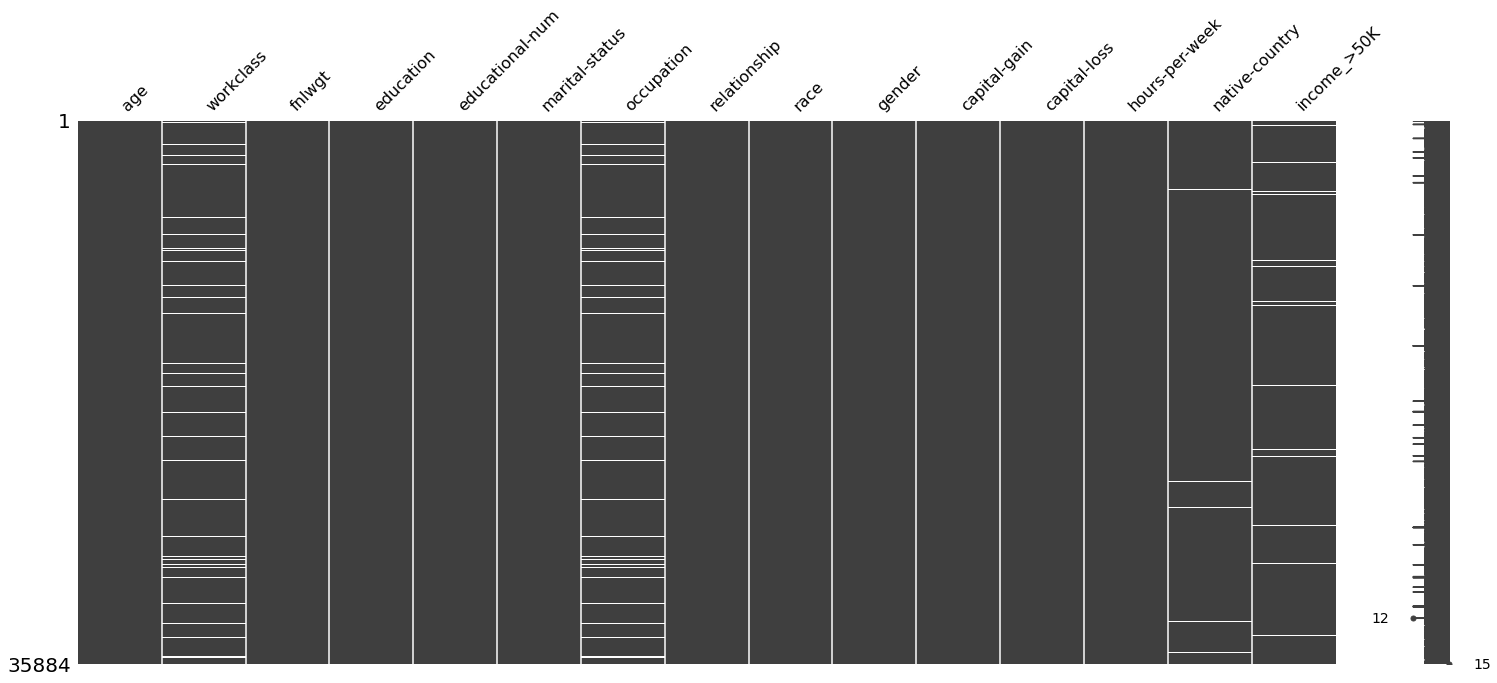

In [17]:
msno.matrix(train_copy)
plt.show()

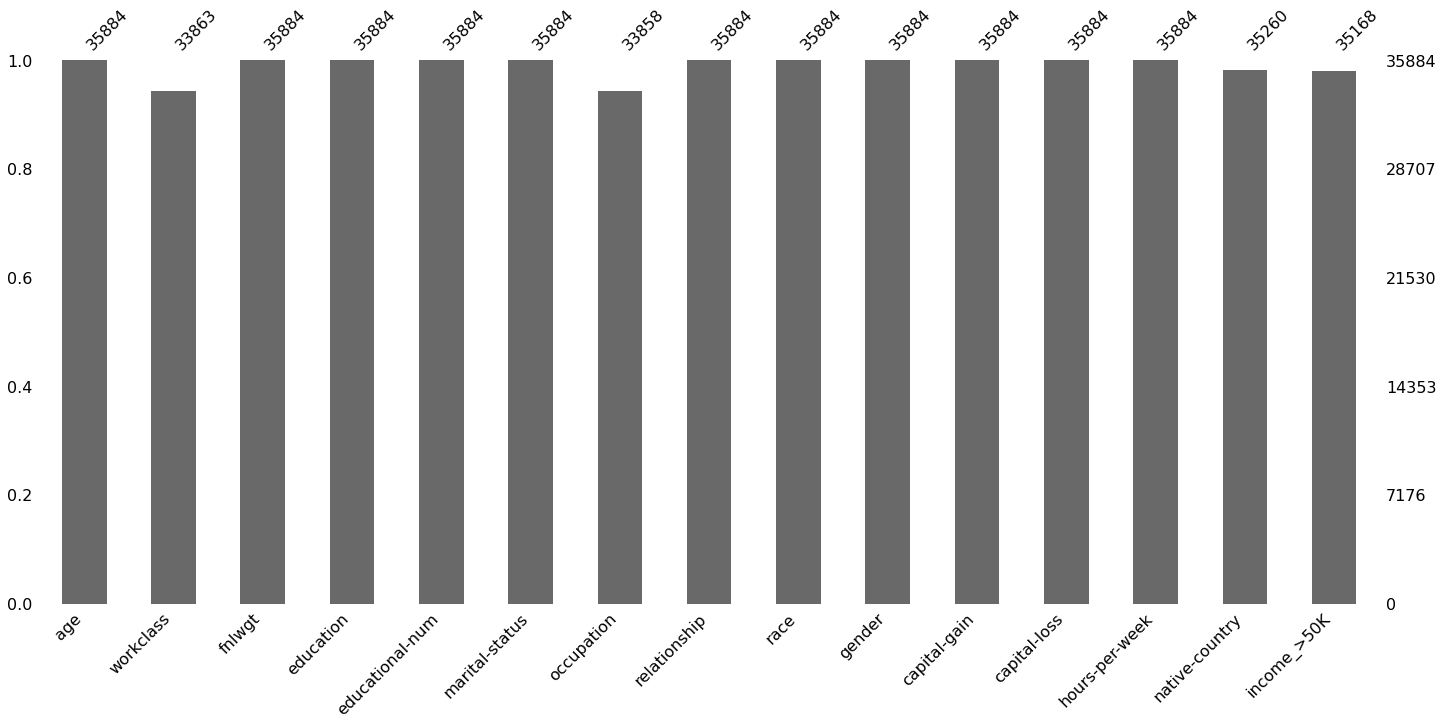

In [18]:
msno.bar(train_copy)
plt.show()

In [19]:
#profile_report = ProfileReport(train_copy, explorative=True, dark_mode=True)

In [20]:
profile_report_file_path = Path('income_class_profile.html')

try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("income_class_profile.html")
else:
    pass

## 3.4 Study each attribute and its characteristics:
## - Name
## - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
## - % of missing values
## - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
## - Possibly useful for the task?
## - Type of distribution (Gaussian, uniform, logarithmic, etc.)

In [21]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### 3.4.1 Age

In [22]:
train_copy['age'].head()

0    43
1    60
2    64
3    41
4    27
Name: age, dtype: int64

In [23]:
train_copy['age'].describe()

count    35884.000000
mean        38.611749
std         13.731157
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [24]:
train_copy['age'].dtype

dtype('int64')

In [25]:
train_copy['age'].isnull().sum()

0

In [26]:
age_value_cnt_norm = train_copy['age'].value_counts(normalize=True) * 100

In [27]:
age_value_cnt = train_copy['age'].value_counts()

In [28]:
value_cnt_norm_cal(train_copy, 'age')

,Count,Frequency (%)
33,1003,2.795118
35,1003,2.795118
36,1000,2.786757
31,972,2.708728
23,971,2.705941
...,...,...
88,4,0.011147
87,2,0.005574
85,2,0.005574
89,2,0.005574


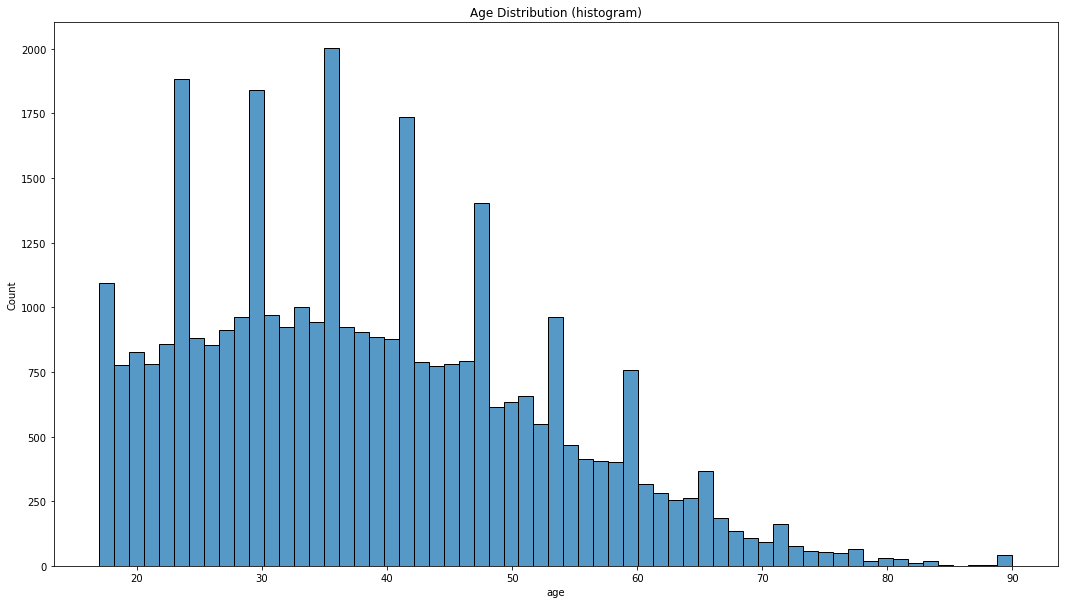

In [29]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['age'])
plt.title('Age Distribution (histogram)')
plt.show()

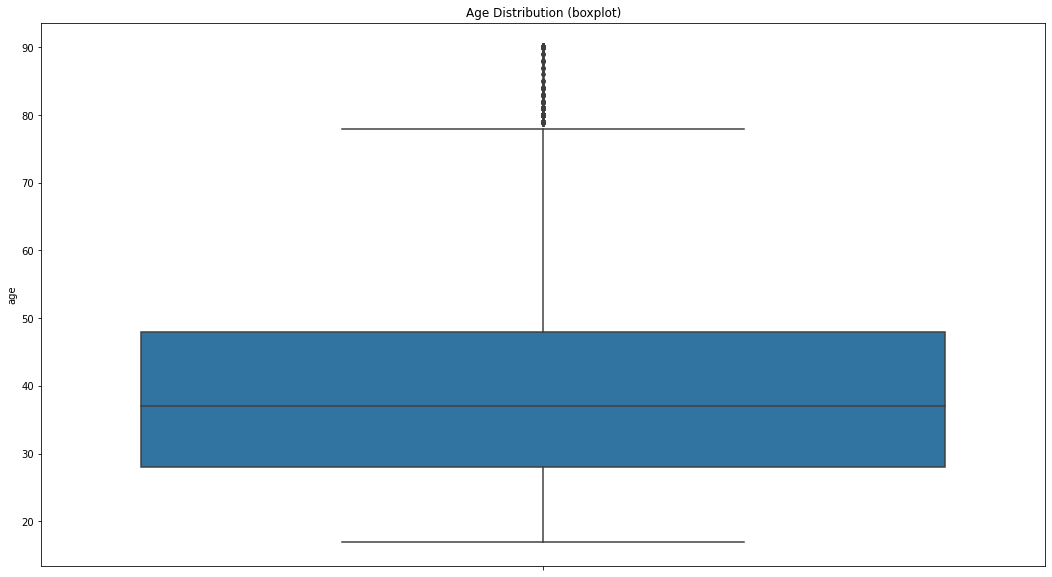

In [30]:
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(y=train_copy['age'])
plt.title('Age Distribution (boxplot)')
plt.show()

In [31]:
# TODO: Age is might be useful for the model, will keep it for now

### 3.4.2 Workclass

In [32]:
train_copy['workclass'].dtype

dtype('O')

In [33]:
train_copy['workclass'].head()

0         Private
1         Private
2             NaN
3    Self-emp-inc
4         Private
Name: workclass, dtype: object

In [34]:
value_cnt_norm_cal(train_copy,'workclass')

,Count,Frequency (%)
Private,24991,73.800313
Self-emp-not-inc,2819,8.324720
Local-gov,2305,6.806839
State-gov,1442,4.258335
Self-emp-inc,1238,3.655908
Federal-gov,1051,3.103682
Without-pay,12,0.035437
Never-worked,5,0.014765


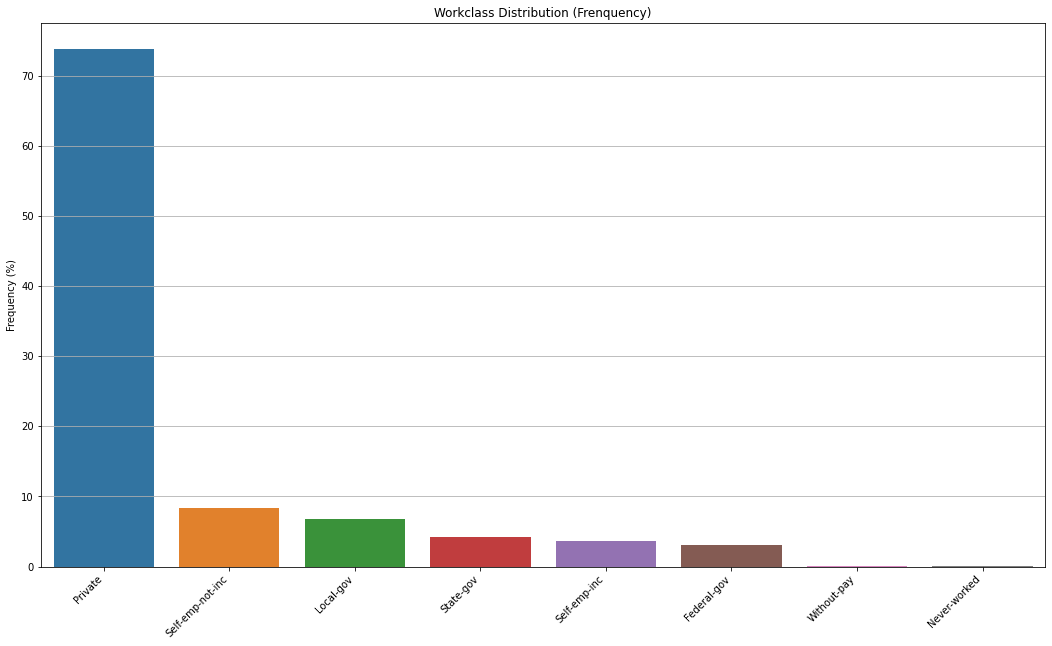

In [35]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Frequency (%)'])
plt.title('Workclass Distribution (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

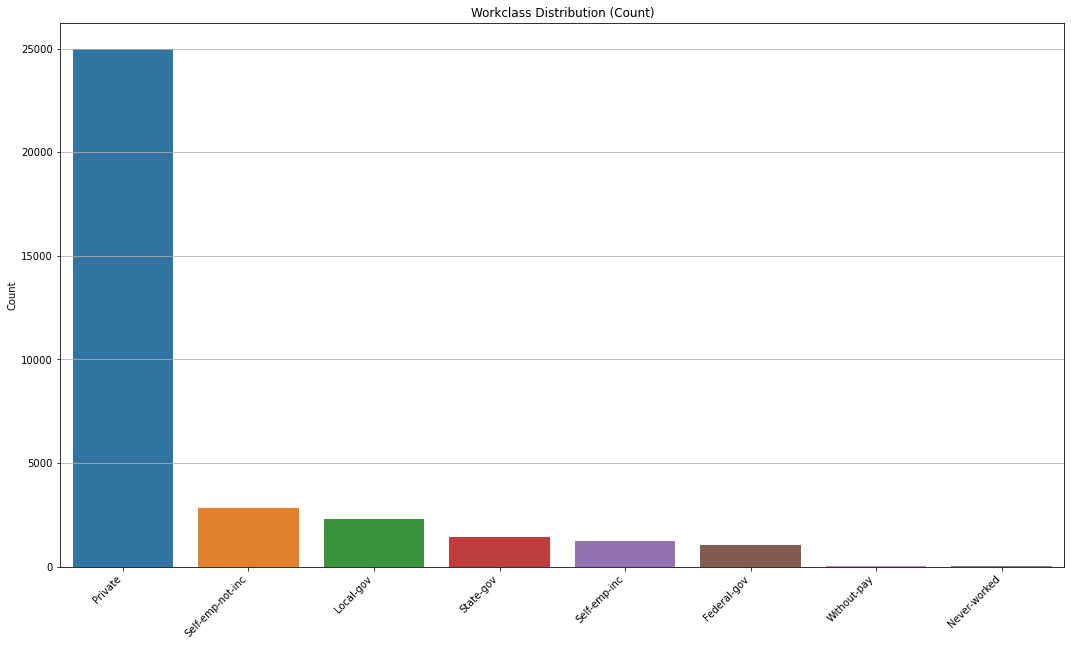

In [36]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Count'])
plt.title('Workclass Distribution (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [37]:
train_copy['workclass'].isnull().sum()

2021

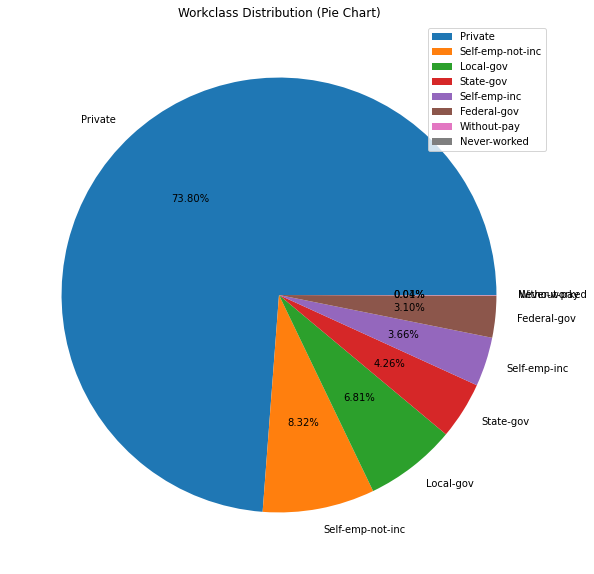

In [38]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['workclass'].value_counts(), labels=train_copy['workclass'].value_counts().index, autopct='%1.2f%%')
plt.title('Workclass Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [39]:
# TODO: workclass is might be useful for the model, will keep it for now

### 3.4.3 Final weight

Its a weight assigned by the Census Bureau. **The idea is that if two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. **Say sample 7,12 and 33 are having similar fnlwgt values they are more likely to be of the same race, similar educational and social background, etc.. but if you are planning to use it, you should be aware that they are not standardized across different states/country. So someone in one country might share similar fnlwgt with somebody in another country but might have entirely different socio-economic background.

In [40]:
train_copy['fnlwgt'].dtype

dtype('int64')

In [41]:
train_copy['fnlwgt'].head()

0    245975
1    198727
2    168340
3    214247
4    289147
Name: fnlwgt, dtype: int64

In [42]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_copy['fnlwgt'].describe()

count     35884.000
mean     189696.174
std      105756.690
min       13492.000
25%      117583.000
50%      177895.500
75%      237943.000
max     1490400.000
Name: fnlwgt, dtype: float64

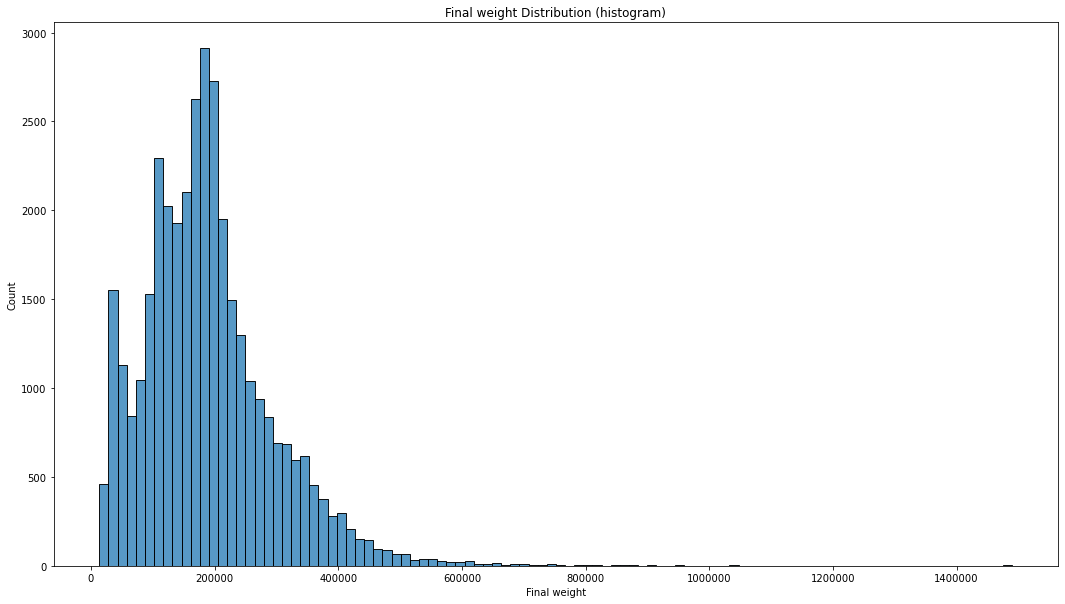

In [43]:
fig, ax = plt.subplots(figsize=(18,10))
ax.ticklabel_format(style='plain')
sns.histplot(train_copy['fnlwgt'],bins=100)
plt.title('Final weight Distribution (histogram)')
plt.xlabel('Final weight')
plt.show()

In [44]:
# TODO: Not sure if this feature is useful, will keep it for now. Will run the feature im and see if this is useful

### 3.4.4. Education

In [45]:
train_copy['education'].dtype

dtype('O')

In [46]:
train_copy['education'].head()

0            9th
1        HS-grad
2        HS-grad
3    Prof-school
4      Bachelors
Name: education, dtype: object

In [47]:
train_copy['education'].isnull().sum()

0

In [48]:
value_cnt_norm_cal(train_copy,'education')

,Count,Frequency (%)
HS-grad,11643,32.446
Some-college,7989,22.263
Bachelors,5897,16.434
Masters,1965,5.476
Assoc-voc,1509,4.205
11th,1319,3.676
Assoc-acdm,1165,3.247
10th,1025,2.856
7th-8th,679,1.892
Prof-school,622,1.733


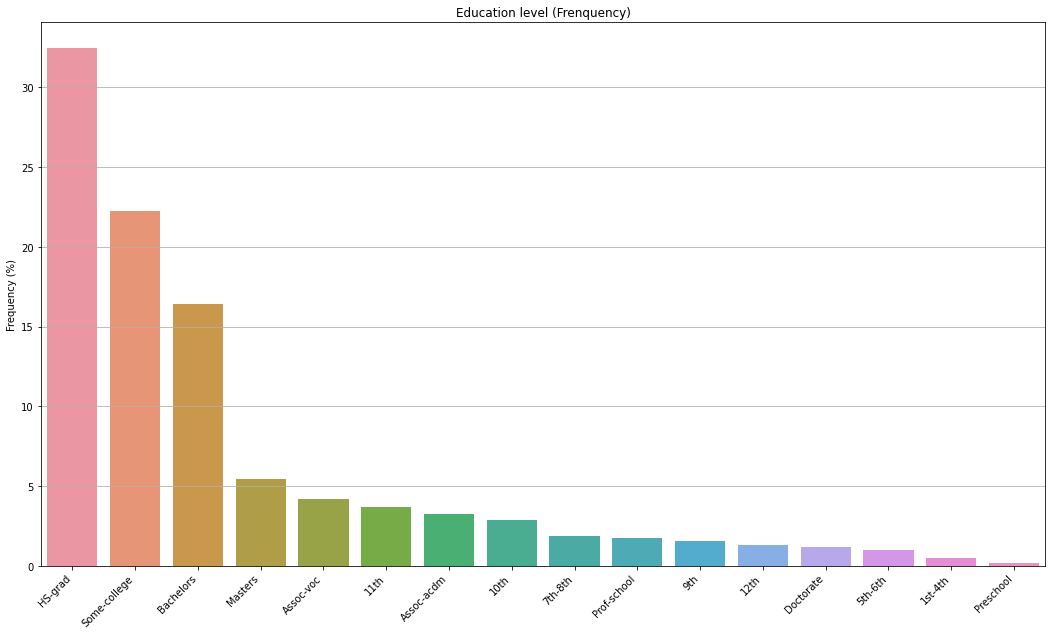

In [49]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Frequency (%)'])
plt.title('Education level (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

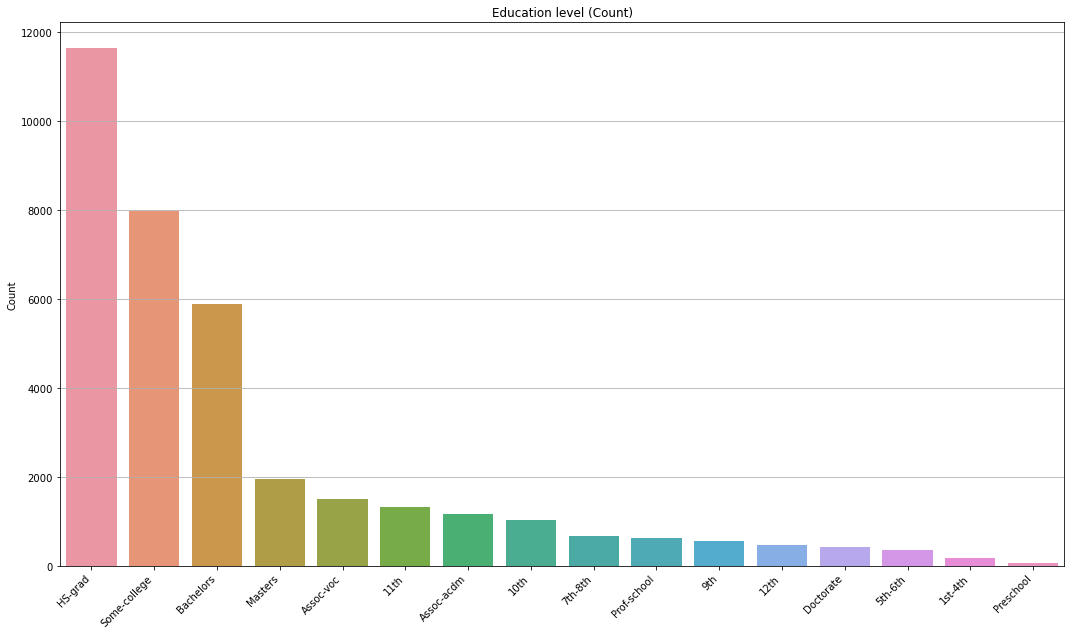

In [50]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [51]:
# TODO: education level is might be useful for the model, will keep it for now

### 3.4.5 education number

In [52]:
train_copy['educational-num'].dtype

dtype('int64')

In [53]:
train_copy['educational-num'].head()

0     5
1     9
2     9
3    15
4    13
Name: educational-num, dtype: int64

In [54]:
train_copy['educational-num'].value_counts()

9     11643
10     7989
13     5897
14     1965
11     1509
7      1319
12     1165
6      1025
4       679
15      622
5       558
8       474
16      421
3       371
2       182
1        65
Name: educational-num, dtype: int64

In [55]:
train_copy[['education','educational-num']].nunique()

education          16
educational-num    16
dtype: int64

In [56]:
train_copy[['education','educational-num']].value_counts()

education     educational-num
HS-grad       9                  11643
Some-college  10                  7989
Bachelors     13                  5897
Masters       14                  1965
Assoc-voc     11                  1509
11th          7                   1319
Assoc-acdm    12                  1165
10th          6                   1025
7th-8th       4                    679
Prof-school   15                   622
9th           5                    558
12th          8                    474
Doctorate     16                   421
5th-6th       3                    371
1st-4th       2                    182
Preschool     1                     65
dtype: int64

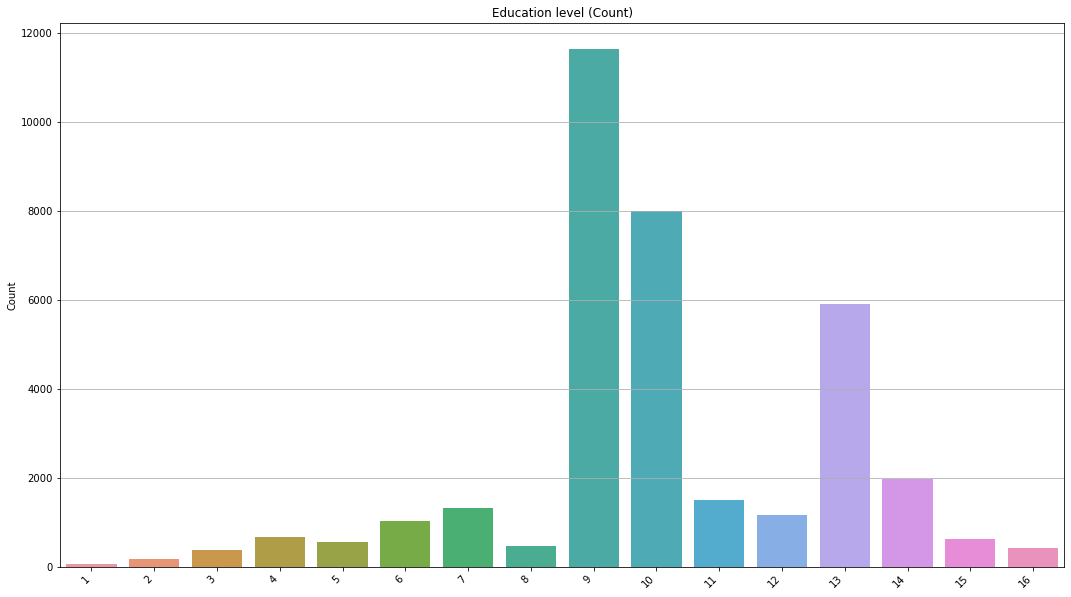

In [57]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'educational-num').index, y=value_cnt_norm_cal(train_copy,'educational-num')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [58]:
# TODO: since education-num is essentially an encoded version of education, will need to drop this feature and keep education for now.

### 3.4.6 Marital Status

In [59]:
train_copy['marital-status'].dtype

dtype('O')

In [60]:
train_copy['marital-status'].head()

0    Married-civ-spouse
1    Married-civ-spouse
2    Married-civ-spouse
3    Married-civ-spouse
4         Never-married
Name: marital-status, dtype: object

In [61]:
train_copy['marital-status'].isnull().sum()

0

In [62]:
value_cnt_norm_cal(train_copy,'marital-status')

,Count,Frequency (%)
Married-civ-spouse,16445,45.828
Never-married,11820,32.939
Divorced,4900,13.655
Widowed,1116,3.110
Separated,1112,3.099
Married-spouse-absent,468,1.304
Married-AF-spouse,23,0.064


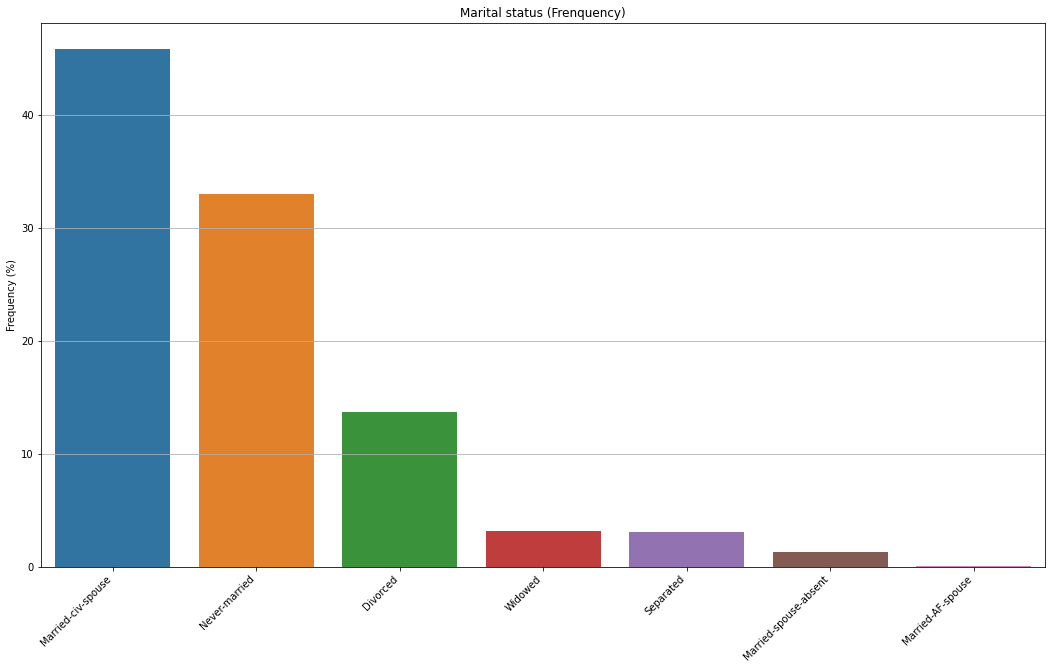

In [63]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Frequency (%)'])
plt.title('Marital status (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

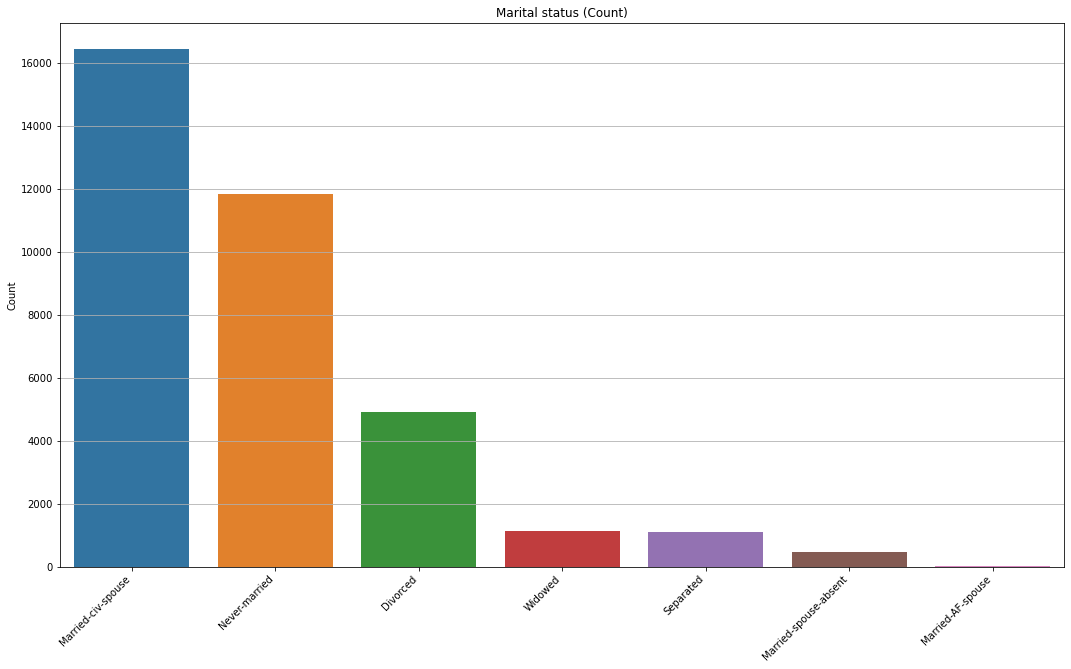

In [64]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Count'])
plt.title('Marital status (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

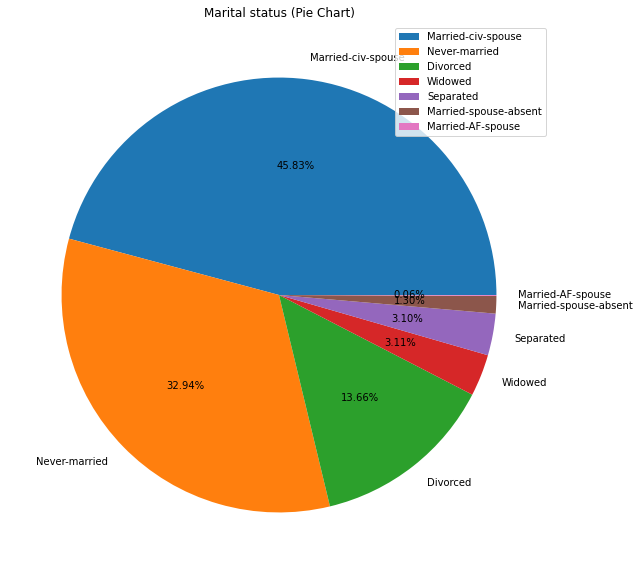

In [65]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['marital-status'].value_counts(), labels=train_copy['marital-status'].value_counts().index, autopct='%1.2f%%')
plt.title('Marital status (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### 3.4.7 Occupation

In [66]:
train_copy['occupation'].dtype

dtype('O')

In [67]:
train_copy['occupation'].head()

0      Adm-clerical
1    Prof-specialty
2               NaN
3    Prof-specialty
4    Prof-specialty
Name: occupation, dtype: object

In [68]:
train_copy['occupation'].isnull().sum()

2026

In [69]:
train_copy['occupation'].value_counts()

Prof-specialty       4550
Craft-repair         4523
Exec-managerial      4494
Adm-clerical         4097
Sales                4081
Other-service        3620
Machine-op-inspct    2224
Transport-moving     1712
Handlers-cleaners    1509
Farming-fishing      1079
Tech-support         1066
Protective-serv       712
Priv-house-serv       179
Armed-Forces           12
Name: occupation, dtype: int64

In [70]:
train_copy['occupation'].nunique()

14

In [71]:
value_cnt_norm_cal(train_copy,'occupation')

,Count,Frequency (%)
Prof-specialty,4550,13.438
Craft-repair,4523,13.359
Exec-managerial,4494,13.273
Adm-clerical,4097,12.101
Sales,4081,12.053
Other-service,3620,10.692
Machine-op-inspct,2224,6.569
Transport-moving,1712,5.056
Handlers-cleaners,1509,4.457
Farming-fishing,1079,3.187


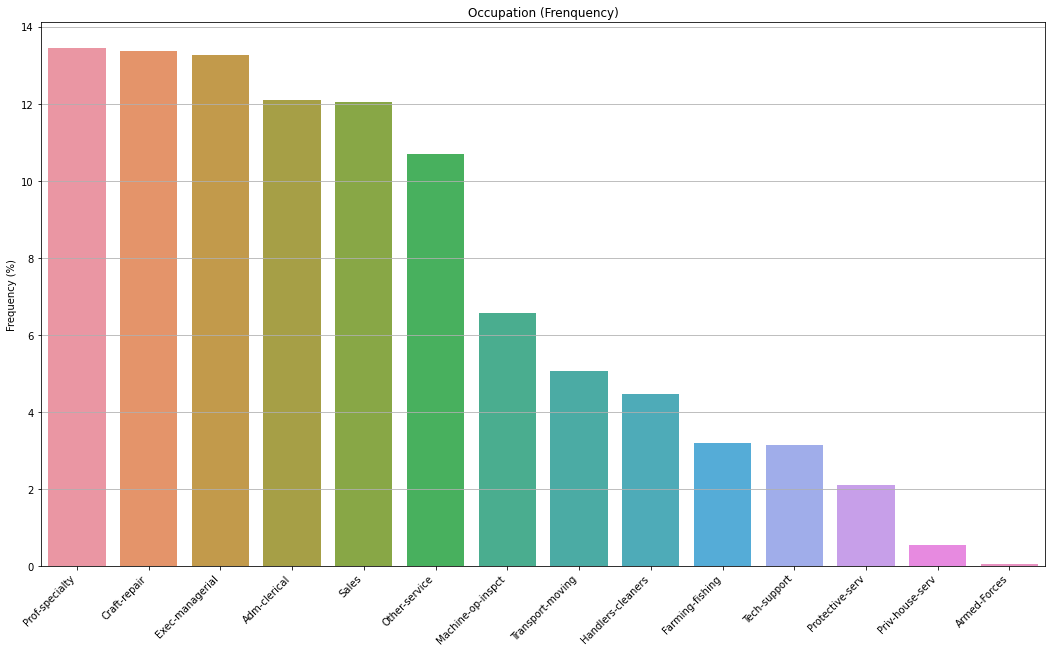

In [72]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Frequency (%)'])
plt.title('Occupation (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

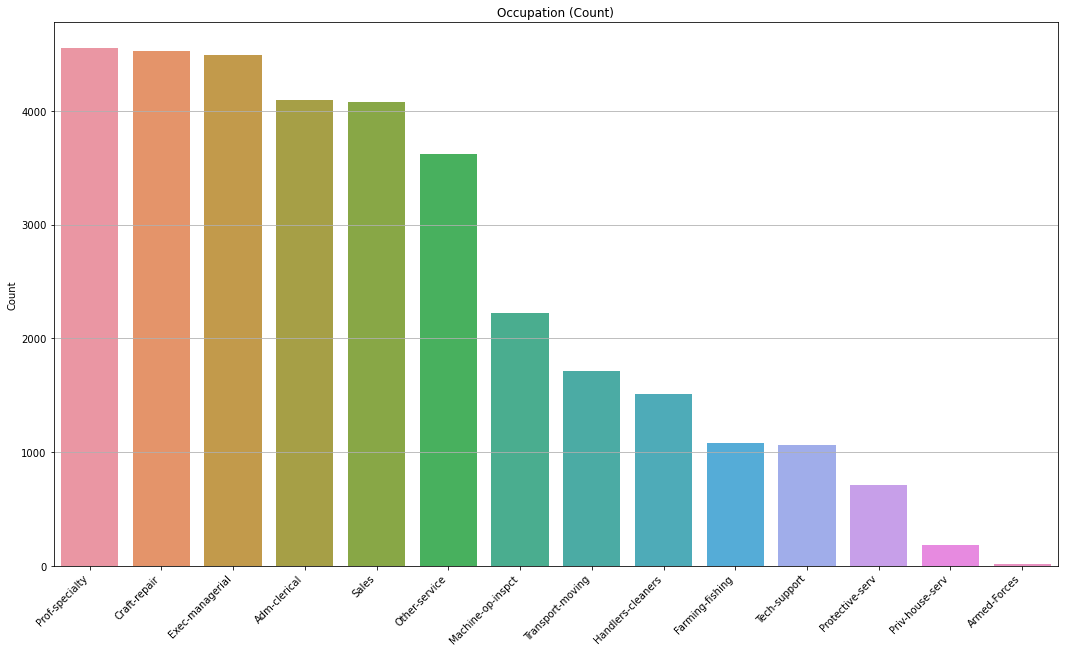

In [73]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Count'])
plt.title('Occupation (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [74]:
## TODO: occupation is highly correlated with workclass, has almost the same missing value like workclass and gives less info than workclass. we might need to drop this feature.

### 3.4.8 relationship

In [75]:
train_copy['relationship'].dtype

dtype('O')

In [76]:
train_copy['relationship'].head()

0      Husband
1      Husband
2      Husband
3      Husband
4    Own-child
Name: relationship, dtype: object

In [77]:
train_copy['relationship'].value_counts()

Husband           14488
Not-in-family      9262
Own-child          5572
Unmarried          3725
Wife               1703
Other-relative     1134
Name: relationship, dtype: int64

In [78]:
train_copy['relationship'].isnull().sum()

0

In [79]:
value_cnt_norm_cal(train_copy,'relationship')

,Count,Frequency (%)
Husband,14488,40.375
Not-in-family,9262,25.811
Own-child,5572,15.528
Unmarried,3725,10.381
Wife,1703,4.746
Other-relative,1134,3.160


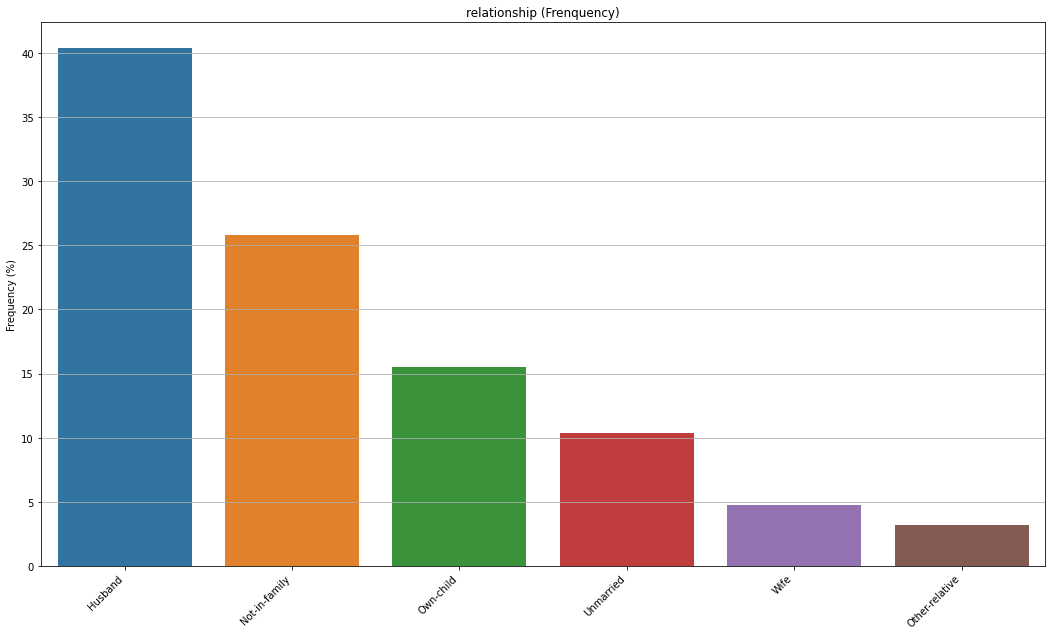

In [80]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Frequency (%)'])
plt.title('relationship (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

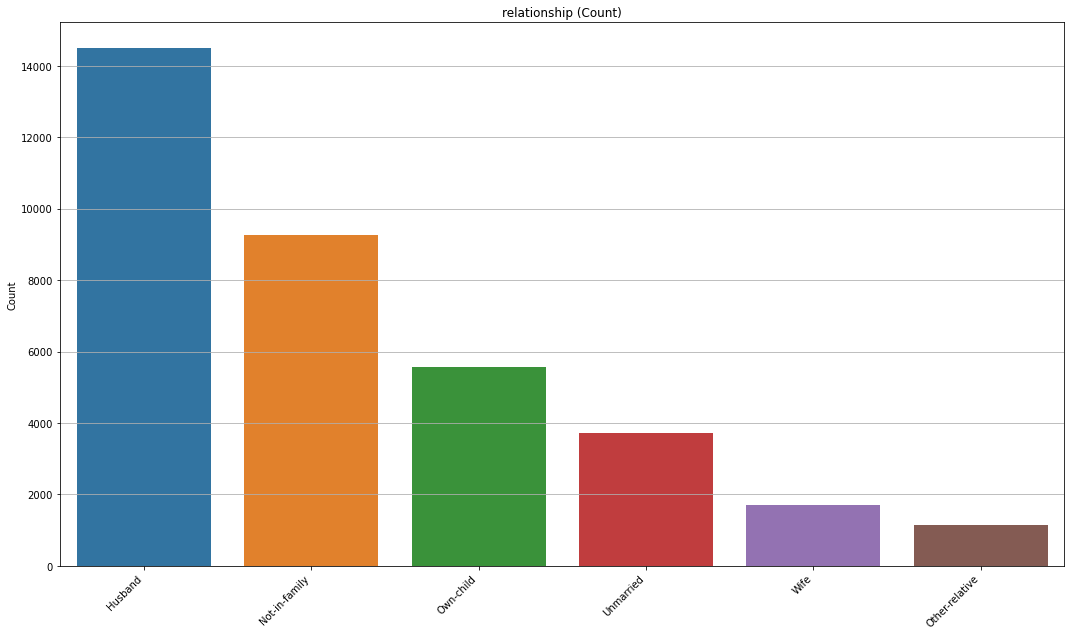

In [81]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Count'])
plt.title('relationship (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

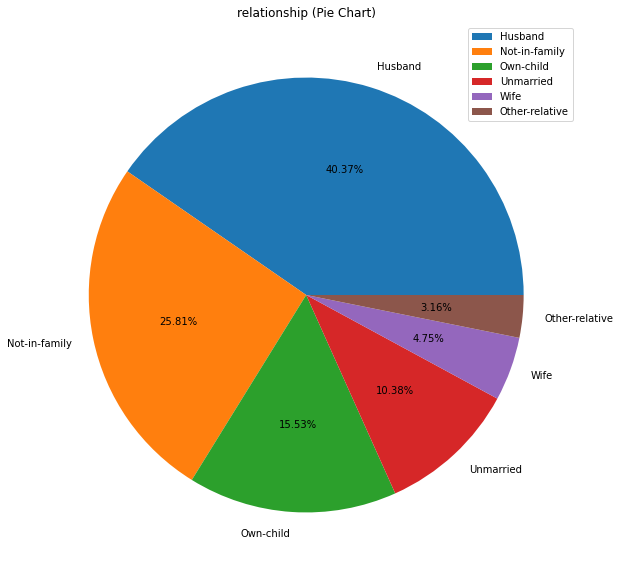

In [82]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['relationship'].value_counts(), labels=train_copy['relationship'].value_counts().index, autopct='%1.2f%%')
plt.title('relationship (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [83]:
# TODO: relationship is highly correlated with Marital status. we might need to drop this feature.

### 3.4.9 Race

In [84]:
train_copy['race'].dtype

dtype('O')

In [85]:
train_copy['race'].isnull().sum()

0

In [86]:
train_copy['race'].head()

0    White
1    White
2    White
3    White
4    White
Name: race, dtype: object

In [87]:
value_cnt_norm_cal(train_copy,'race')

,Count,Frequency (%)
White,30706,85.570
Black,3443,9.595
Asian-Pac-Islander,1093,3.046
Amer-Indian-Eskimo,346,0.964
Other,296,0.825


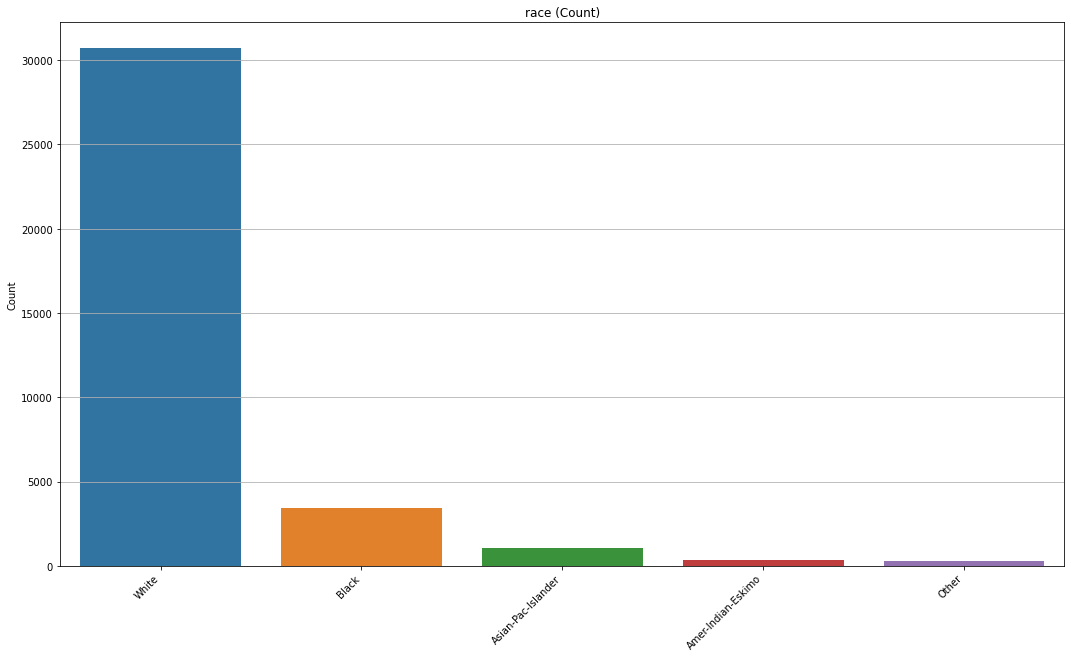

In [88]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Count'])
plt.title('race (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

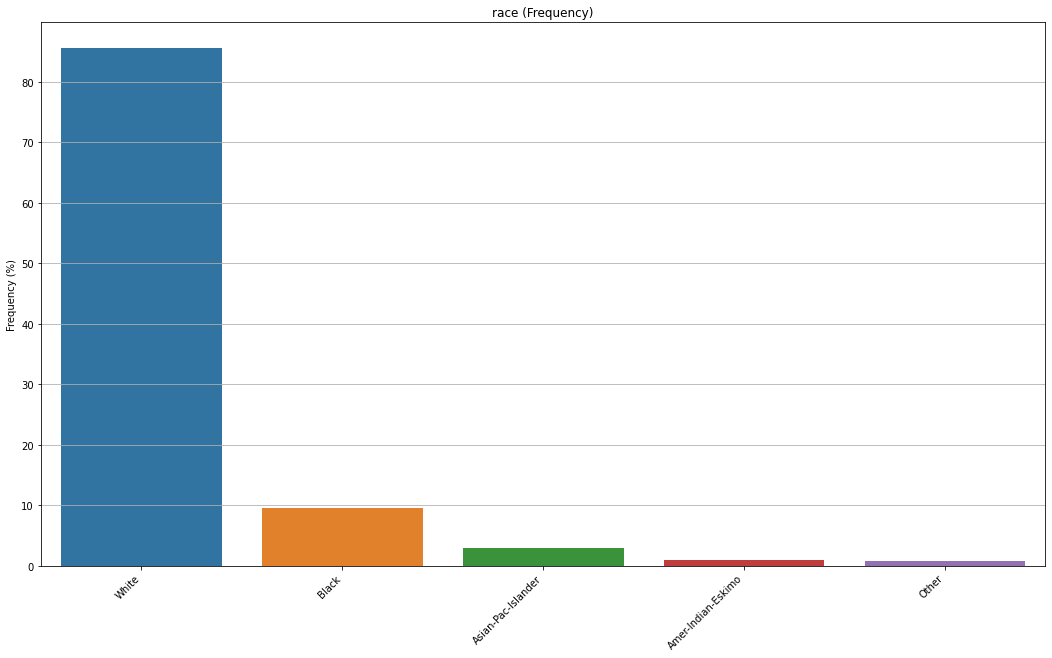

In [89]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Frequency (%)'])
plt.title('race (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

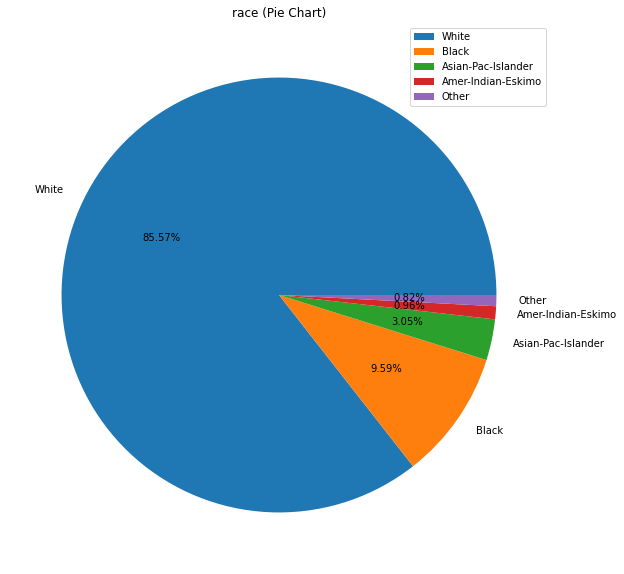

In [90]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['race'].value_counts(), labels=train_copy['race'].value_counts().index, autopct='%1.2f%%')
plt.title('race (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [91]:
# TODO: Race might influence on the salary. will keep it

### 3.4.10 Gender

In [92]:
train_copy['gender'].dtype

dtype('O')

In [93]:
train_copy['race'].isnull().sum()

0

In [94]:
value_cnt_norm_cal(train_copy,'gender')

,Count,Frequency (%)
Male,24003,66.891
Female,11881,33.109


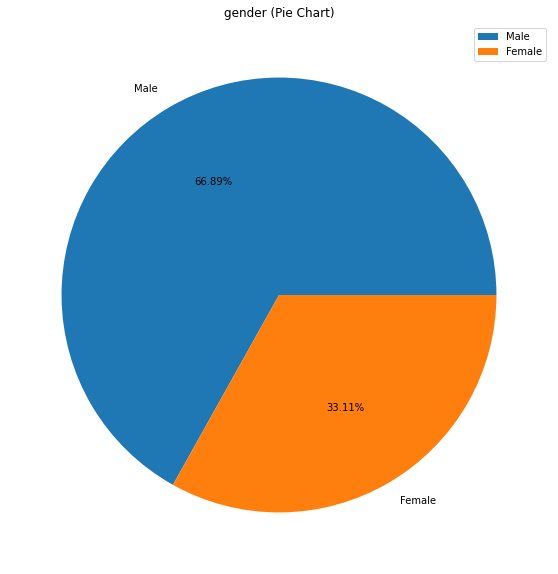

In [95]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['gender'].value_counts(), labels=train_copy['gender'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

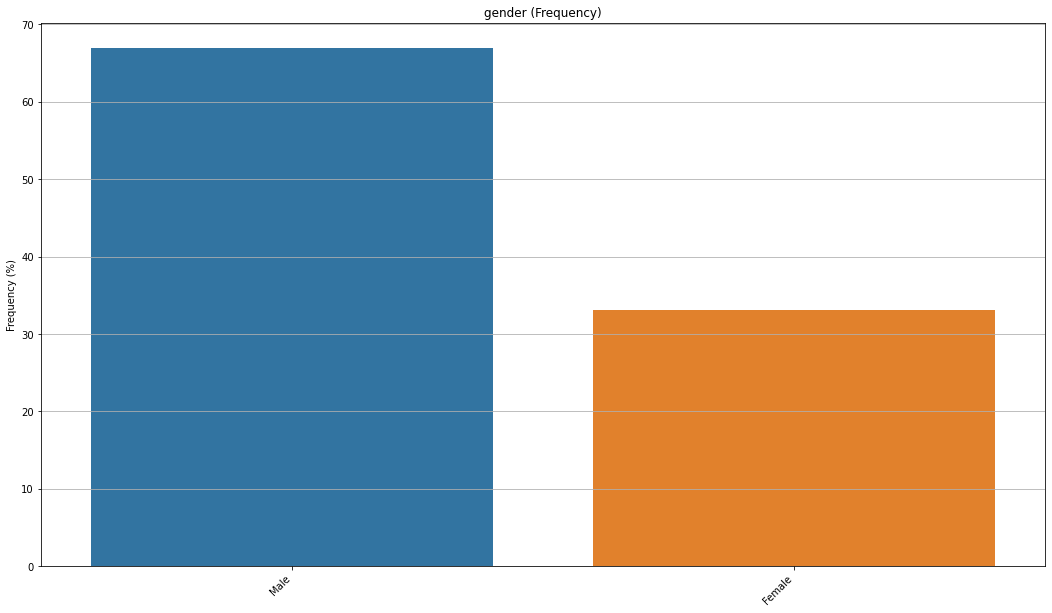

In [96]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Frequency (%)'])
plt.title('gender (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

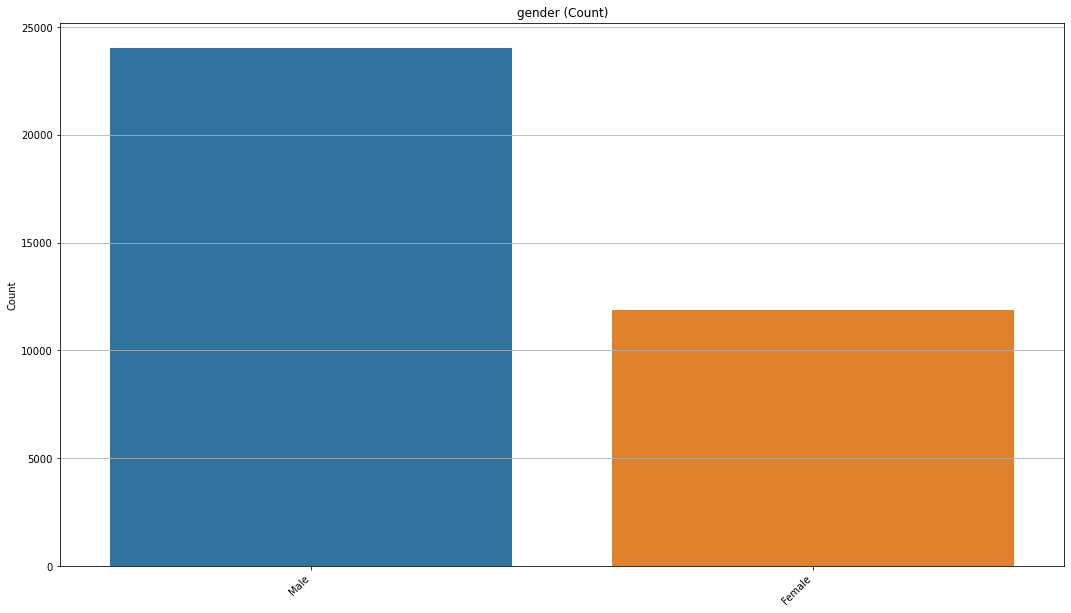

In [97]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Count'])
plt.title('gender (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [98]:
# TODO: Gender might influence on the salary. will keep it

### 3.4.11 capital gain

In [99]:
train_copy['capital-gain'].dtype

dtype('int64')

In [100]:
train_copy['capital-gain'].describe()

count   35884.000
mean     1070.179
std      7419.124
min         0.000
25%         0.000
50%         0.000
75%         0.000
max     99999.000
Name: capital-gain, dtype: float64

In [101]:
train_copy['capital-gain'].isnull().sum()

0

In [102]:
train_copy['capital-gain'].value_counts()

0        32915
15024      361
7688       293
7298       275
99999      178
         ...  
1731         1
22040        1
1639         1
5060         1
6612         1
Name: capital-gain, Length: 121, dtype: int64

In [103]:
train_copy['capital-gain'].shape

(35884,)

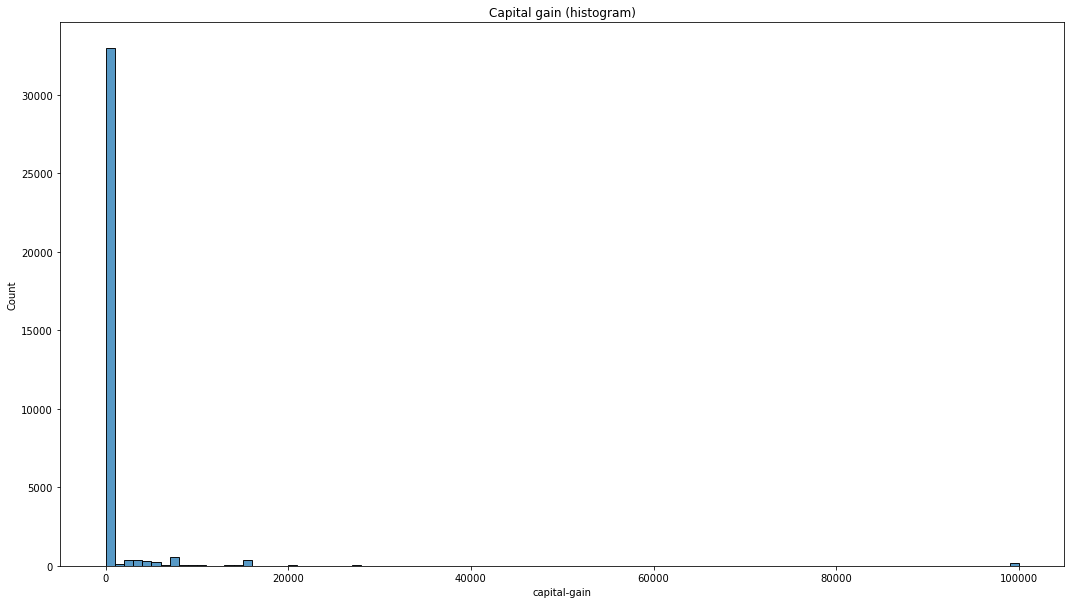

In [104]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-gain'],bins=100)
plt.title('Capital gain (histogram)')
plt.show()

In [105]:
# TODO: Capital gain is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.12 capital loss

In [106]:
train_copy['capital-loss'].dtype

dtype('int64')

In [107]:
train_copy['capital-loss'].describe()

count   35884.000
mean       87.970
std       404.224
min         0.000
25%         0.000
50%         0.000
75%         0.000
max      4356.000
Name: capital-loss, dtype: float64

In [108]:
train_copy['capital-loss'].isnull().sum()

0

In [109]:
train_copy['capital-loss'].value_counts()

0       34197
1902      235
1977      177
1887      168
2415       57
        ...  
2163        1
974         1
2201        1
155         1
1421        1
Name: capital-loss, Length: 97, dtype: int64

In [110]:
train_copy['capital-loss'].shape

(35884,)

In [111]:
value_cnt_norm_cal(train_copy,'capital-loss')

,Count,Frequency (%)
0,34197,95.299
1902,235,0.655
1977,177,0.493
1887,168,0.468
2415,57,0.159
...,...,...
2163,1,0.003
974,1,0.003
2201,1,0.003
155,1,0.003


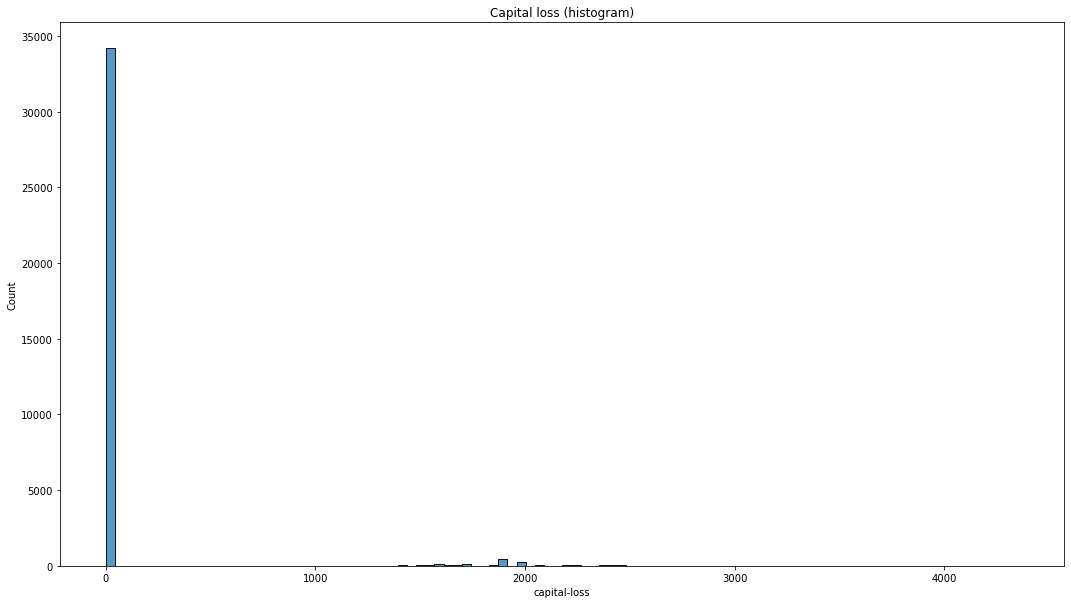

In [112]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-loss'],bins=100)
plt.title('Capital loss (histogram)')
plt.show()

In [113]:
# TODO: Capital loss is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.13 Hours per week

In [114]:
train_copy['hours-per-week'].dtype

dtype('int64')

In [115]:
train_copy['hours-per-week'].describe()

count   35884.000
mean       40.363
std        12.383
min         1.000
25%        40.000
50%        40.000
75%        45.000
max        99.000
Name: hours-per-week, dtype: float64

In [116]:
value_cnt_norm_cal(train_copy,'hours-per-week')

,Count,Frequency (%)
40,16777,46.753
50,3118,8.689
45,2014,5.613
60,1605,4.473
35,1457,4.060
...,...,...
88,1,0.003
94,1,0.003
95,1,0.003
79,1,0.003


In [117]:
train_copy['hours-per-week'].isnull().sum()

0

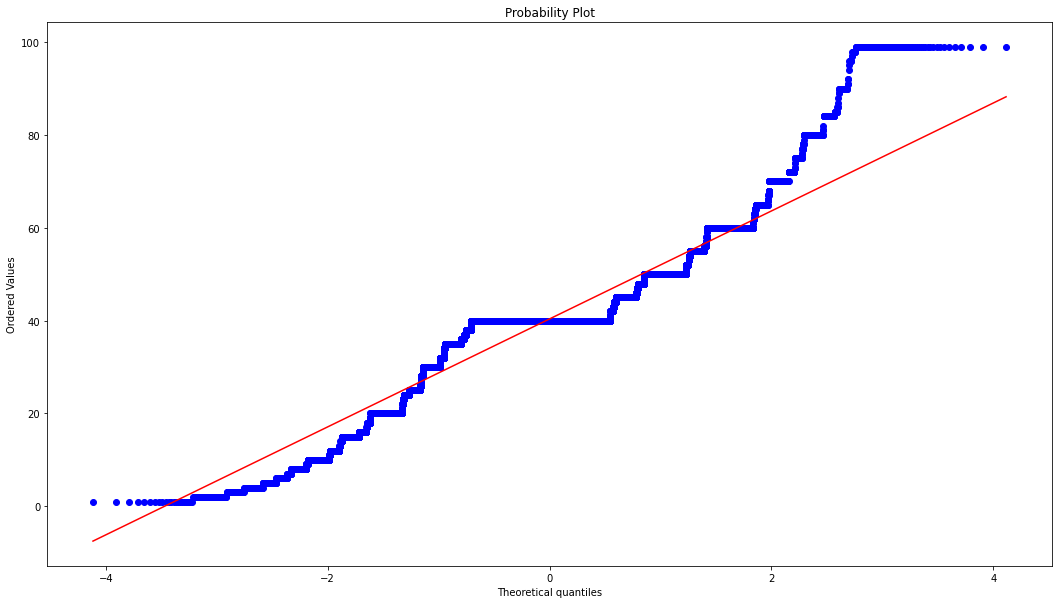

In [118]:
#checking if hours-per-week is normally distributed
fig, ax = plt.subplots(figsize=(18,10))
probplot(train_copy['hours-per-week'], dist="norm", plot=ax)
plt.show()

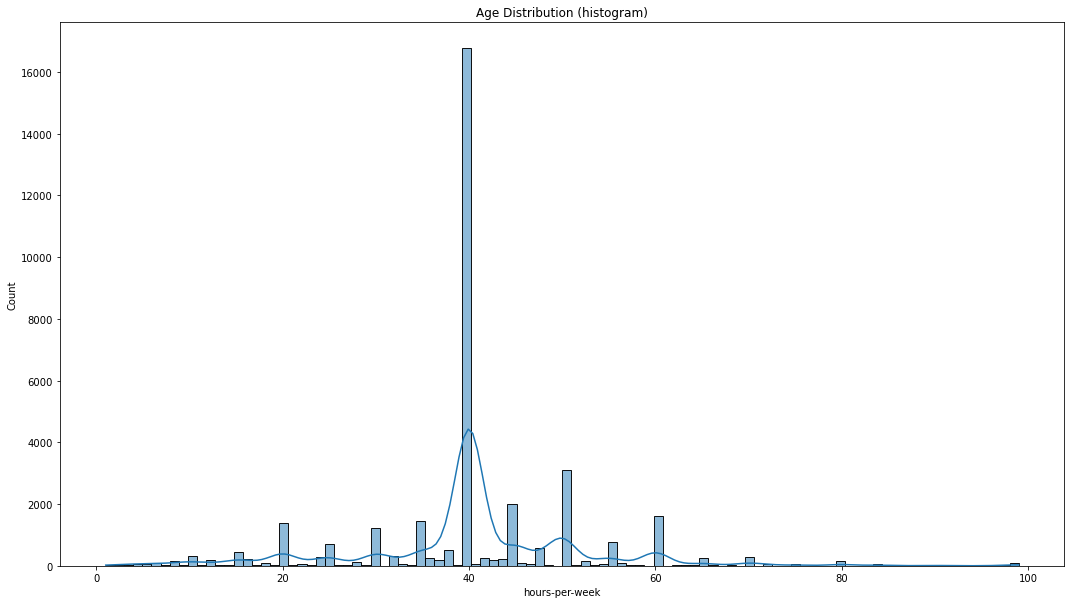

In [119]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['hours-per-week'],bins=100,kde=True)
plt.title('Age Distribution (histogram)')
plt.show()

In [120]:
# TODO: Hours per week might be useful. will keep it

### 3.4.14 Native country

In [121]:
train_copy['native-country'].dtype

dtype('O')

In [122]:
train_copy['native-country'].isnull().sum()

624

In [123]:
value_cnt_norm_cal(train_copy,'native-country')

,Count,Frequency (%)
United-States,32233,91.415
Mexico,720,2.042
Philippines,204,0.579
Germany,142,0.403
Puerto-Rico,135,0.383
Canada,127,0.360
India,113,0.320
El-Salvador,113,0.320
England,102,0.289
Cuba,97,0.275


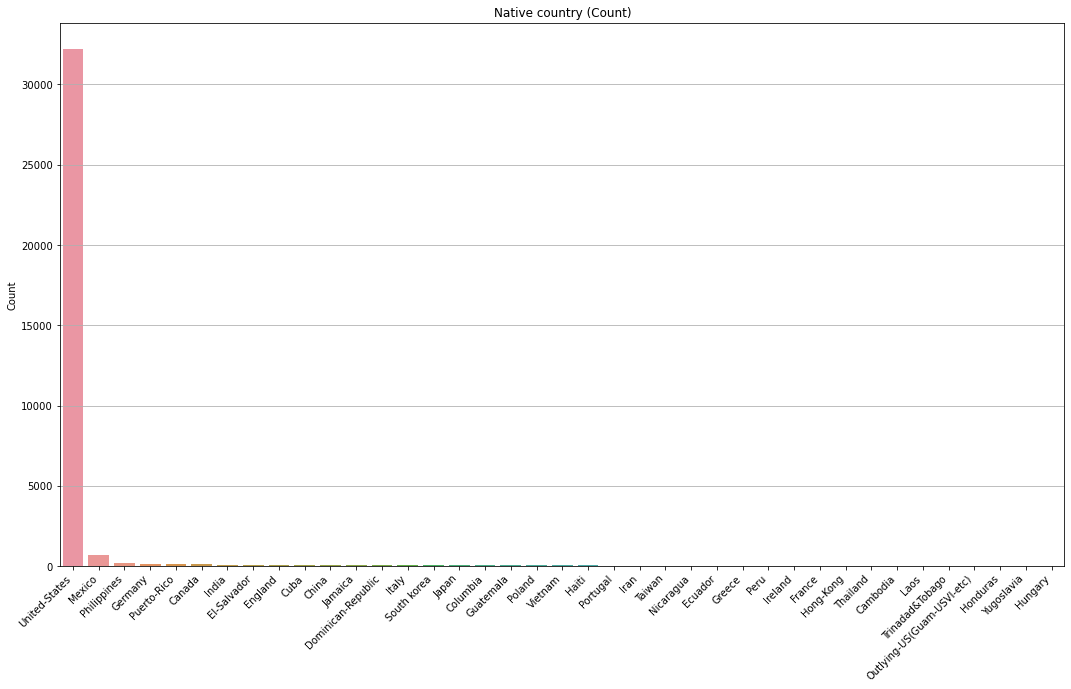

In [124]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Count'])
plt.title('Native country (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

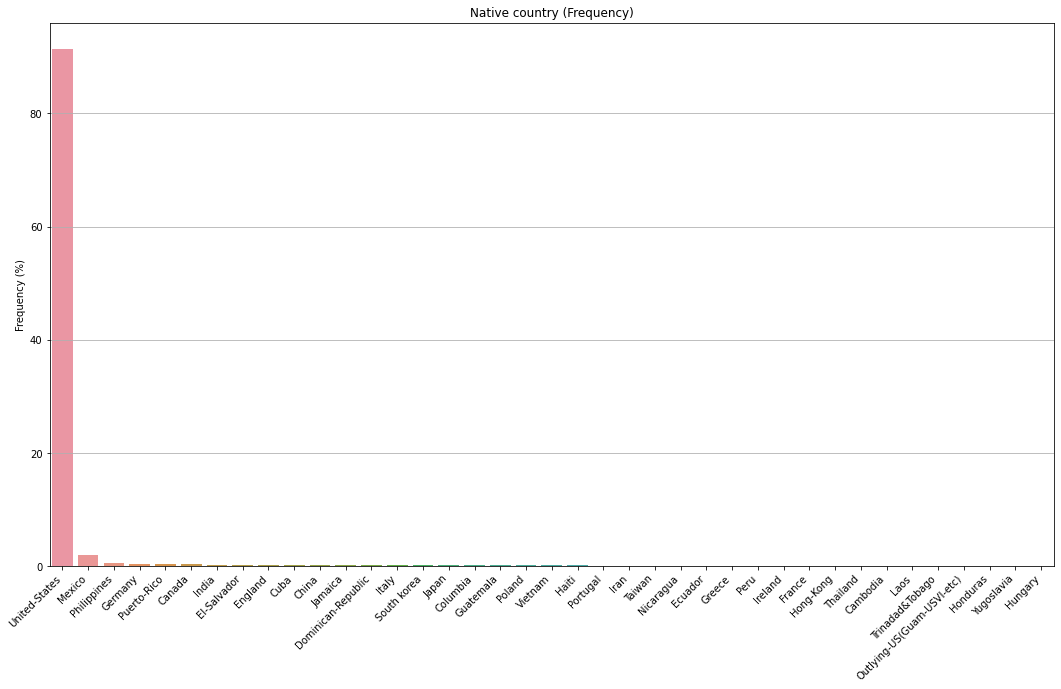

In [125]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [126]:
# TODO: Native country might be useful but most of the datapoint represent United States. we might need to ingore the other countries.

### 3.4.15 Income > 50 K

In [127]:
train_copy['income_>50K'].dtype

dtype('float64')

In [128]:
train_copy['income_>50K'].isnull().sum()

716

In [129]:
value_cnt_norm_cal(train_copy,'income_>50K')

,Count,Frequency (%)
0.000,26792,76.183
1.000,8376,23.817


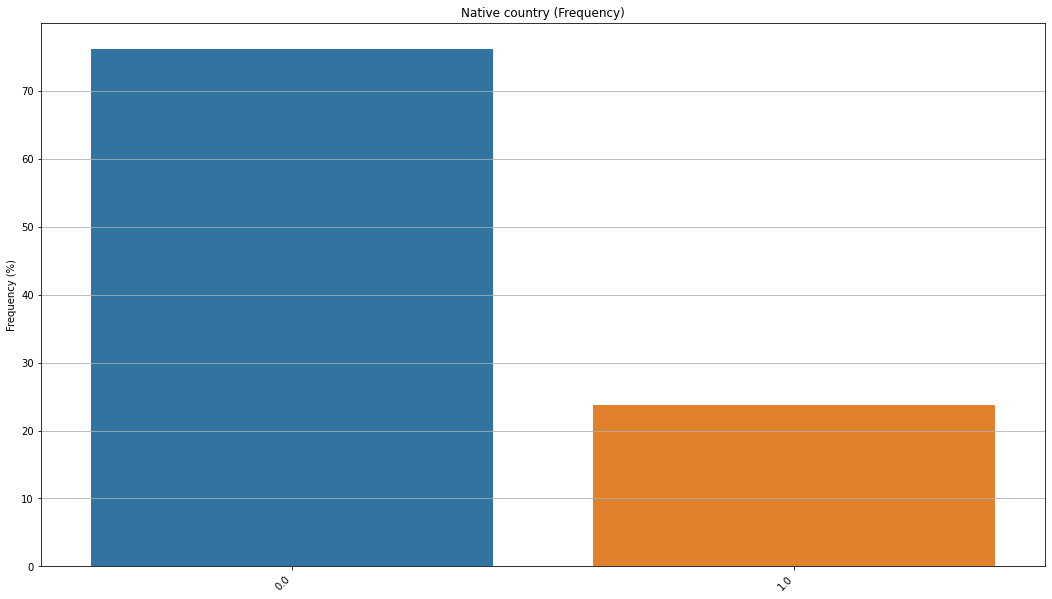

In [130]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'income_>50K').index, y=value_cnt_norm_cal(train_copy,'income_>50K')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()


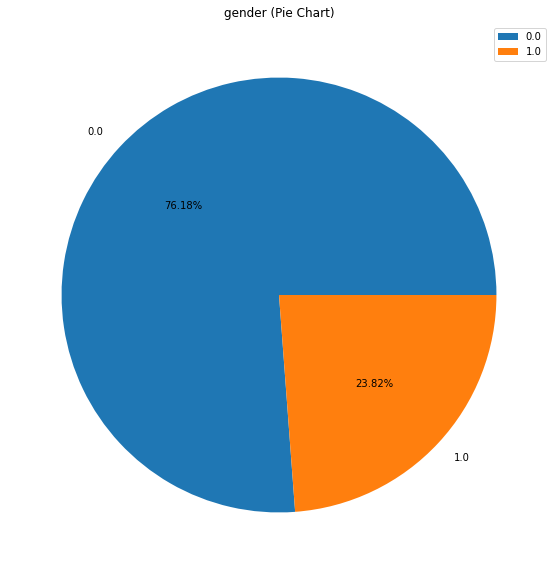

In [131]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['income_>50K'].value_counts(), labels=train_copy['income_>50K'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [132]:
# TODO: Our target is imbalance, we will need to oversample before training the model

## 3.5 For supervised learning tasks, identify the target attribute(s).

Tager attribute is the income > 50K

## 3.6 Visualize the data.

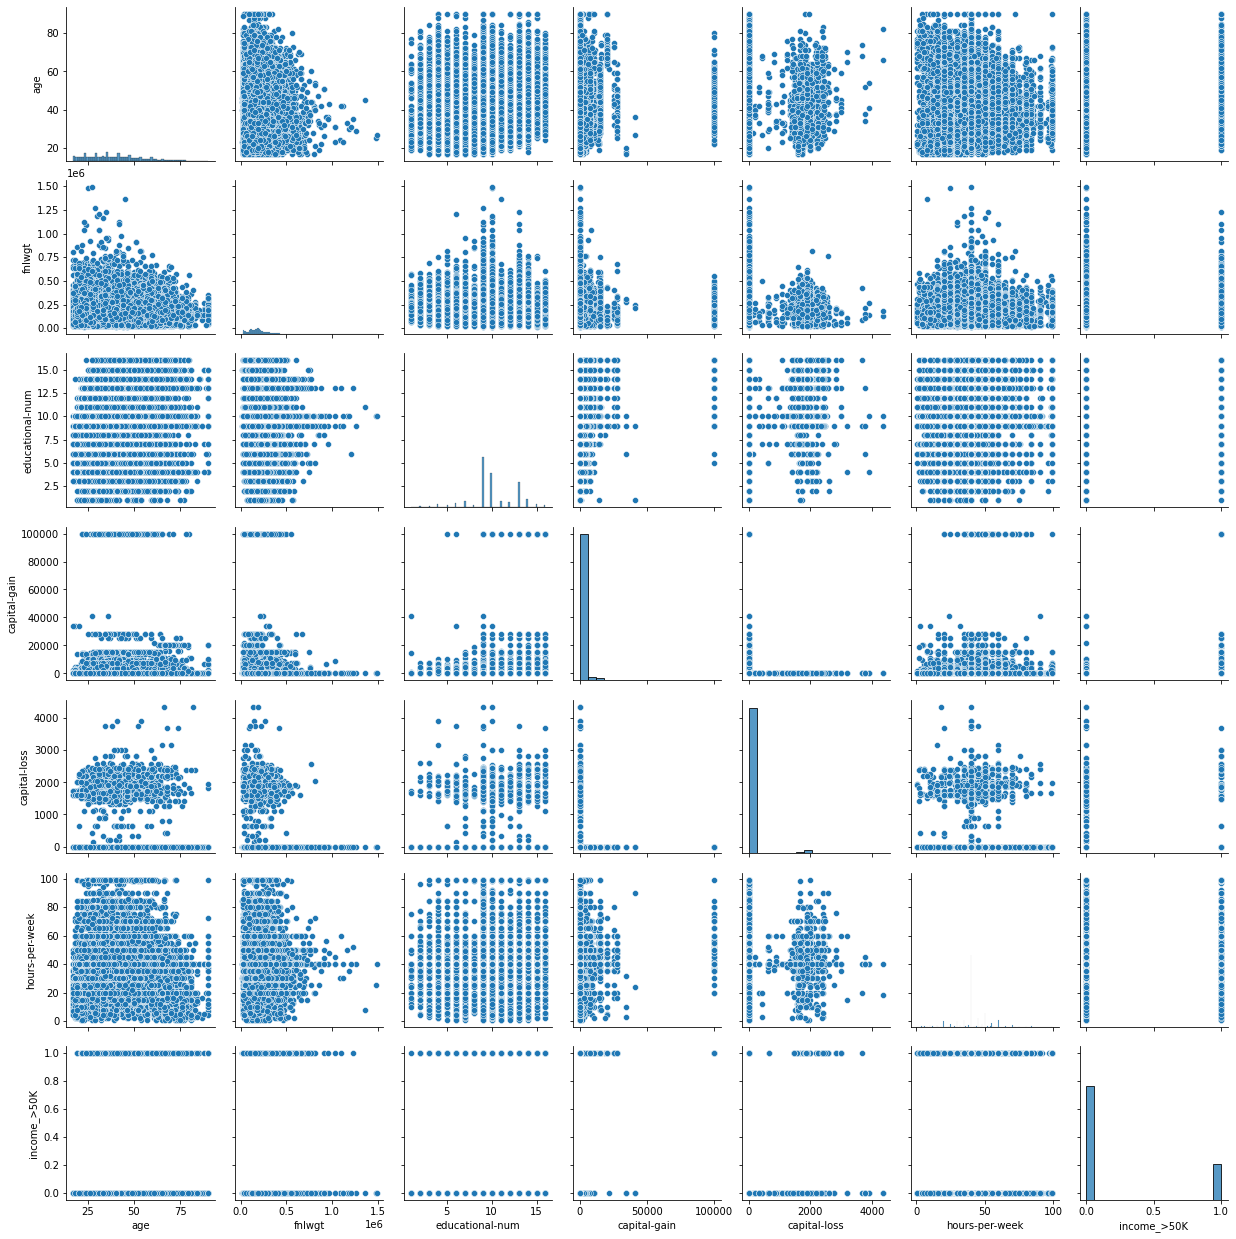

In [133]:
sns.pairplot(train_copy)
plt.show()

## 3.7 Study the pairwise interactions and correlations between attributes.

### 3.7.1 Age vs hours per week (Numerical vs Numerical feature)

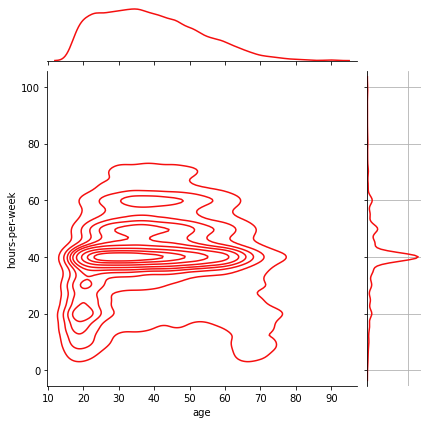

In [134]:
sns.jointplot(x='age', y='hours-per-week', data=train_copy, kind="kde", color="#f50f0f")
plt.grid()
plt.show()

### 3.7.2 Age vs educational number (Numerical vs Numerical feature)

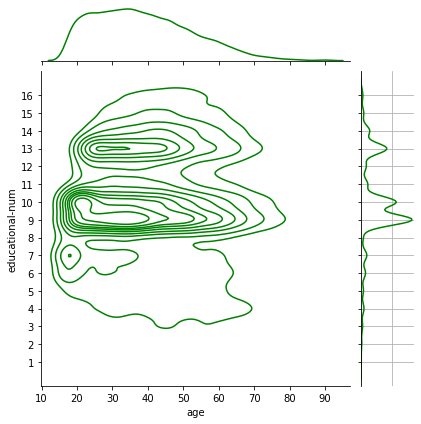

In [135]:
sns.jointplot(x='age', y='educational-num', data=train_copy, kind="kde", color="g")
plt.yticks(np.arange(1, train_copy['educational-num'].nunique()+1, 1))
plt.grid()
plt.show()

In [136]:
education_education_num_relation = pd.DataFrame(train_copy[['education','educational-num']].value_counts()).sort_values(by=['educational-num'], ascending=True).drop([0],axis=1)

In [137]:
education_education_num_relation

,
education,educational-num
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


### 3.7.3 Educational-num vs hours-per-week (Numerical vs Numerical feature)

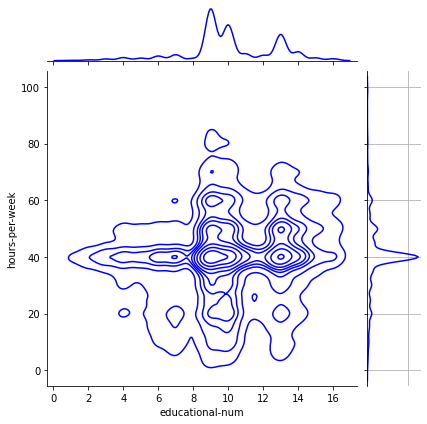

In [138]:
sns.jointplot(x='educational-num', y='hours-per-week', data=train_copy, kind="kde", color="b")
plt.grid()

### 3.7.4 Educational-num vs age (Numerical vs Numerical feature)

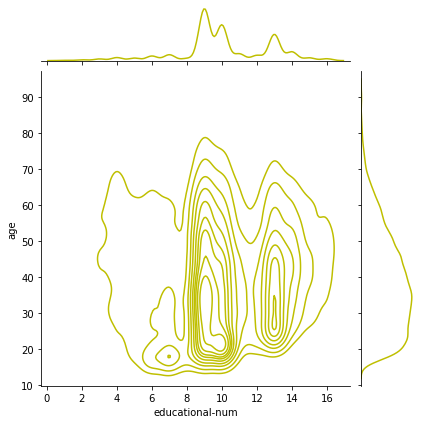

In [139]:
sns.jointplot(x='educational-num', y='age', data=train_copy, kind="kde", color="y")
plt.show()

### 3.7.5 Chi2 test for all the the categorical features (Categorical vs Categorical feature)

In [140]:
def chi2_test(feature_1,feature_2,show_contingency_table=False):
    # creating a cross tabulation of the two features
    feat_1_2_crosstab = pd.crosstab(train_copy[feature_1], train_copy[feature_2])
    stat, p, dof, cont_table = chi2_contingency(feat_1_2_crosstab)
    cont_table_df = pd.DataFrame(cont_table, index=feat_1_2_crosstab.index, columns=feat_1_2_crosstab.columns)
    # toggling the boolean to show the contingency table
    if show_contingency_table:
        print(cont_table_df)
    print('\n')
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('\n')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # Different implementation of chi2 test

    # df_ft_1 = df[feature_1].dropna(axis=0, how='any')
    # df_ft_2 = df[feature_2].dropna(axis=0, how='any')
    # data_crosstab = pd.crosstab(df_ft_1,df_ft_2,margins=True, margins_name="Total")

    # # significance level
    # alpha = 0.05

    # Calculation of Chisquare test statistics
    # chi_square = 0
    # rows = df_ft_1.unique()
    # columns = df_ft_2.unique()
    # for i in columns:
    #     for j in rows:
    #         O = data_crosstab[i][j]
    #         E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
    #         chi_square += (O-E)**2/E

    # # The p-value approach
    # print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    # p_value = 1 - norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if p_value <= alpha:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", p_value)
    # print(conclusion)
    # # The critical value approach
    # print("\n--------------------------------------------------------------------------------------")
    # print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
    # critical_value = chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if chi_square > critical_value:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", critical_value)
    # print(conclusion)

In [141]:
all_cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income_>50K']

In [142]:
for i in all_cat_features:
    for j in all_cat_features:
        chi2_test(i,j)



probability=0.950, critical=66.339, stat=237041.000
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=129.918, stat=2619.832
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=58.124, stat=1246.927
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=99.617, stat=9346.978
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=49.802, stat=1382.245
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=41.337, stat=481.773
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=14.067, stat=722.759
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=305.041, stat=491.398
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (re

### 3.7.6 ANOVA test of age vs the rest of categoricals features (Numerical vs continuous feature)

In [143]:
all_cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country',
 'income_>50K']

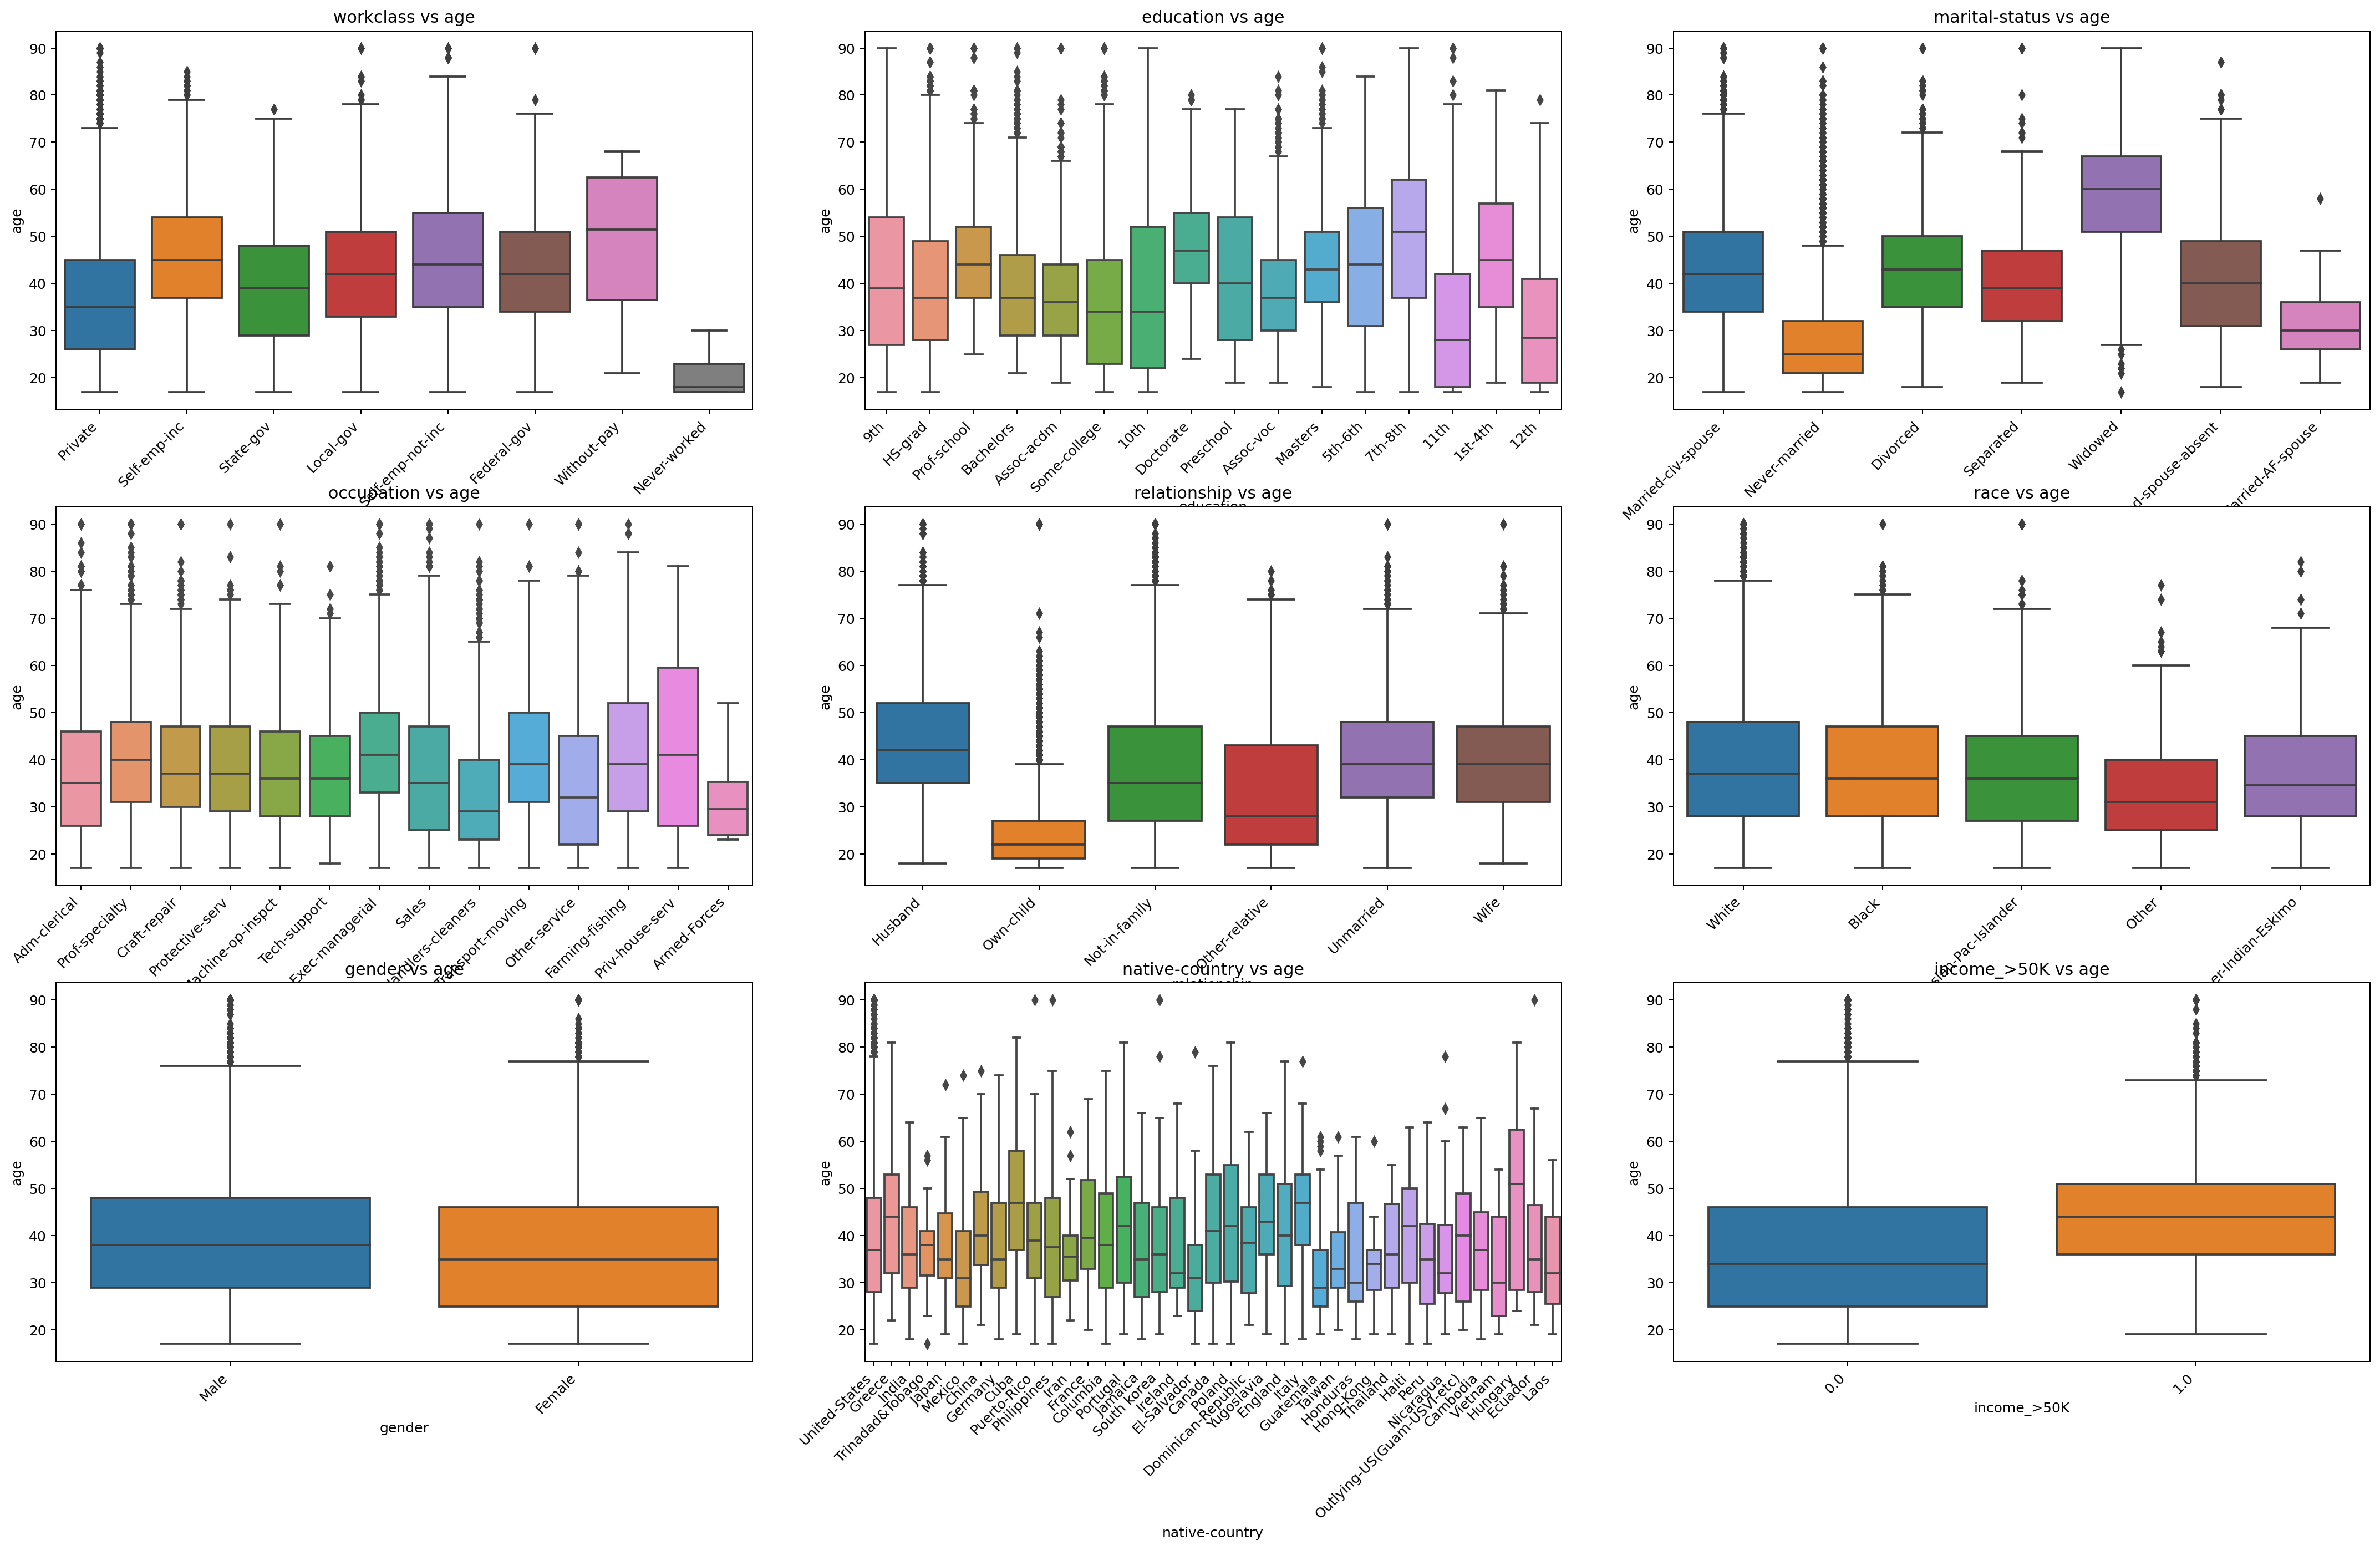

In [144]:
fig, axes = plt.subplots(3,3,figsize=(25,15),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(3):
        for col_count in range(3):
            sns.boxplot(ax=axes[row_count,col_count],x=train_copy[all_cat_features[cat_ft_count]],y=train_copy['age'])
            axes[row_count,col_count].set_title(all_cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,col_count])
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

### 3.7.7 Correlation between features

In [145]:
train_copy_corr = train_copy.corr()

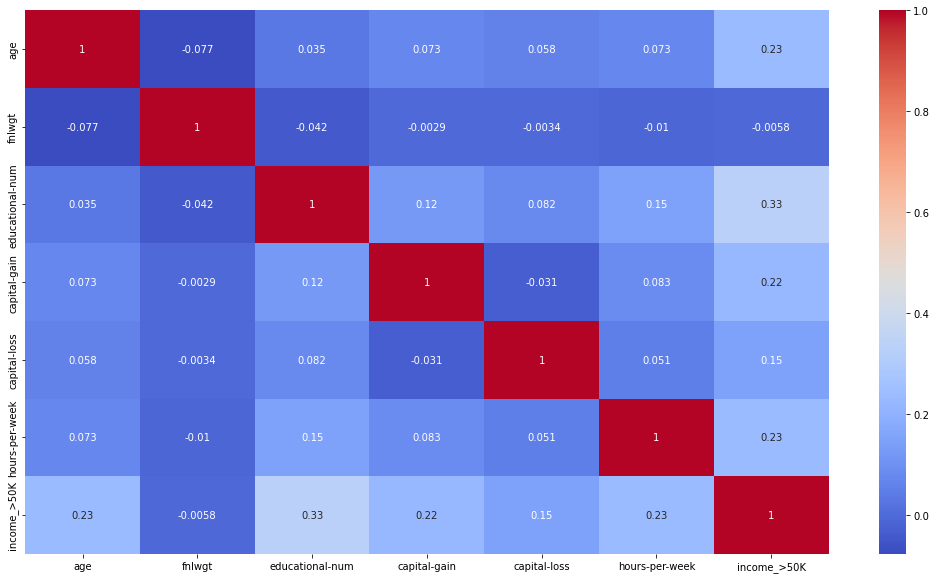

In [146]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(train_copy_corr, annot=True, cmap='coolwarm')
plt.show()

In [147]:
mask = np.zeros_like(train_copy_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
train_copy_corr[mask] = np.nan
(train_copy_corr
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')
)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
age,nan,nan,nan,nan,nan,nan,nan
fnlwgt,-0.077320,nan,nan,nan,nan,nan,nan
educational-num,0.034765,-0.041543,nan,nan,nan,nan,nan
capital-gain,0.072910,-0.002903,0.123113,nan,nan,nan,nan
capital-loss,0.057840,-0.003401,0.082125,-0.031393,nan,nan,nan
hours-per-week,0.072692,-0.010148,0.149159,0.083079,0.050947,nan,nan
income_>50K,0.231173,-0.005844,0.333302,0.223577,0.146871,0.230544,nan


## 3.8 Study how you would solve the problem manually.

I would look at the correlation between the features and the target variable. the strongest correlation with the target variable is the age, educational-num, capital-gain and hours-per-week.

## 3.9 Identify the promising transformations you may want to apply.

Age:
- Drop outliers
- Min Max Scaling
- Fix skewness

Workclass:
- drop the feature because highly correlated with occupation with less information (To be done after running the model and seeing the feature importance method)
- one hot encoding

Fnwgt:
- drop the feature because there is no correlation with target

Education:
- One hot encoding

Education-num:
- drop the column(because we will use education feature)

Marital-status:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Occupation:
- One hot encoding
- Handle missing values

Relation:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Race:
- One hot encoding

Gender:
- One hot encoding

Capital gain:
- Fix skewness
- Min Max Scaling

Capital loss:
- Fix skewness
- Min Max Scaling

Hours per week:
- Min Max Scaling

Native country:
- Groupe countries into 3 GDP Categories (High, Medium, Low GDP)
- drop the feature because we have extracted the 3 GDP categories

GDP Category(extracted from the Native country):
- One hot encoding those categories

Income (Target):
- Fix imbalance data(SMOTE or oversampling)




## 3.10 Identify extra data that would be useful

In [148]:
# GDP data that will be used to group the countries by their GDP
# GDP data of countries in 1990
# Using 1990 data because the Train and test data is an old dataset. How do I know that? One of the country name is Yugoslavia which is no longer since the mid-1990's.
gdp_data = pd.read_csv('datasets/GDP.csv')

In [149]:
gdp_data.sort_values(by='1990' , inplace=True,ascending=False)

In [150]:
gdp_data.reset_index(inplace=True, drop=True)

In [151]:
gdp_data.rename(columns={'Country Name':'native-country','1990':'GDP_1990'},inplace=True)

In [152]:
gdp_data

,native-country,GDP_1990
0,Monaco,84303.880
1,United Arab Emirates,71359.170
2,Brunei,54713.545
3,Liechtenstein,49373.610
4,Luxembourg,29664.795
...,...,...
191,Afghanistan,292.000
192,Mozambique,244.601
193,Eritrea,147.000
194,Somalia,126.920


In [153]:
def add_gdp_data(train_copy,test_copy,gdp_data):
        full_data_copy = pd.concat([train_copy,test_copy],ignore_index=True)
        gdp_group = []
        for idx in gdp_data.index:
            if idx <= 65:
                gdp_group.append('High GDP')
            elif idx >= 65 and idx <= 130:
                gdp_group.append('Medium GDP')
            else:
                gdp_group.append('Low GDP')

        # concatenate the gdp_data with the gdp_group list
        gdp_data = pd.concat([gdp_data.rename(columns={'country':'native-country'}), pd.Series(gdp_group, name='GDP Group')], axis=1)
        # we no longer need the GDP column, so let's drop it
        gdp_data.drop(['GDP_1990'],axis=1,inplace=True)

        # we need to merge the gdp_data with X dataframe
        full_data_copy = pd.merge(full_data_copy, gdp_data, on='native-country', how='left')
        # make income_>50K the last column
        new_col_order = [col for col in full_data_copy.columns if col != 'income_>50K'] + ['income_>50K']
        return full_data_copy[new_col_order]


In [154]:
full_data_copy = add_gdp_data(train_copy,test_copy,gdp_data)

In [155]:
train_copy, test_copy = data_split(full_data_copy,0.2)

## 3.11 Document what you have learned.

All the categorical features are highly correlated (category vs category) and the age and marital status, relationship are highly correlated (numerical vs continuous), finally target is highly correlated with the education, capital gain, age, hour-per-week (numerical vs numerical). 

# 4. Prepare the data for the model

## 4.1 Data cleaning

### 4.1.1 Fix or remove outliers

In [156]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_outliers = ['age']):
        self.col_with_outliers = col_with_outliers
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_outliers).issubset(X.columns)):
            Q1 = X[self.col_with_outliers].quantile(.25)
            Q3 = X[self.col_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.col_with_outliers] < (Q1 - 1.5 * IQR)) | (X[self.col_with_outliers] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        else:
            print("Columns not found")
            return X

### 4.1.2 Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).

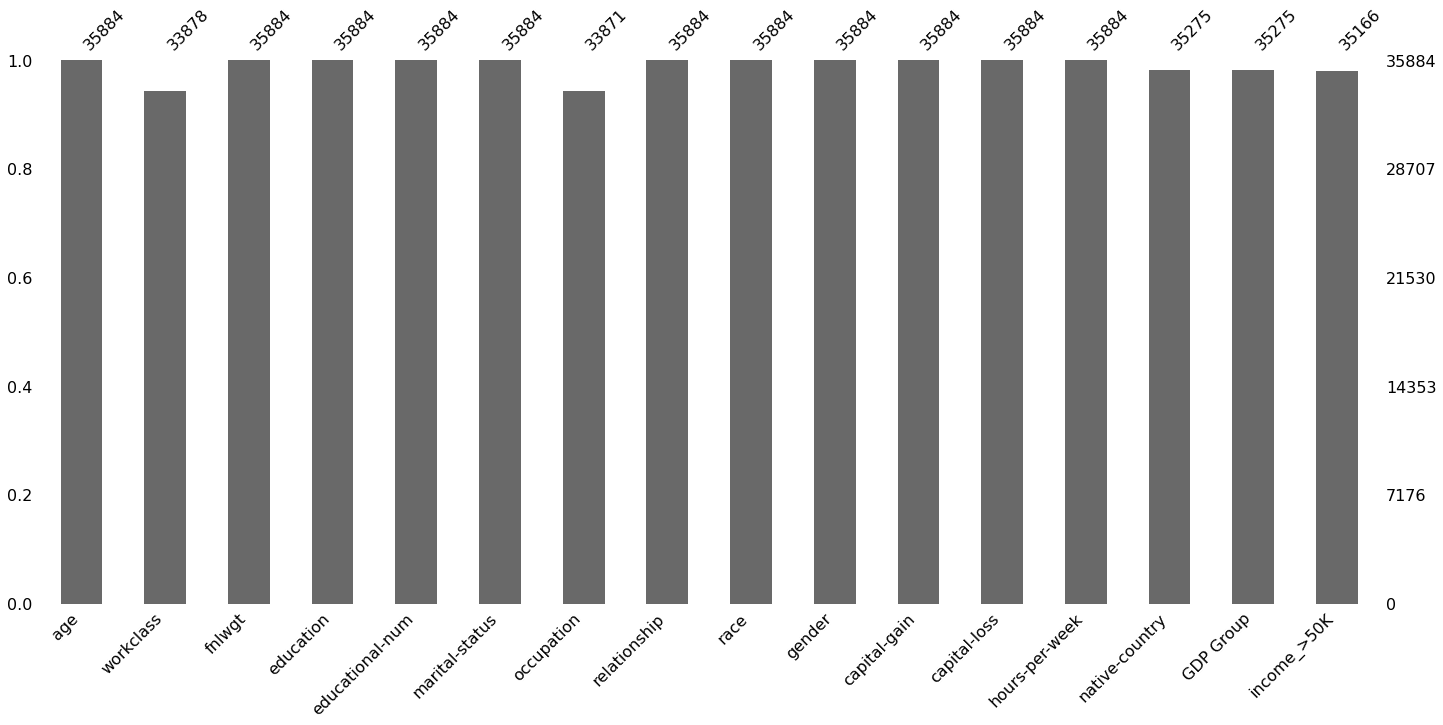

In [157]:
msno.bar(train_copy)
plt.show()

In [158]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_nan=['workclass','occupation','native-country','income_>50K']):
        self.col_with_nan = col_with_nan
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_nan).issubset(X.columns)):
            # the occupation that are null with a not null workclass are for people who have never worked. We will impute those observations in the occupation by something more explicit like 'unemployed'.
            workclass_notnull_occ_null_idx = X[(X['workclass'].notnull()) & (X['occupation'].isnull())].index
            # disable chained assignments warning since the function is using X as a copy of the original dataframe
            pd.options.mode.chained_assignment = None
            X['occupation'].iloc[workclass_notnull_occ_null_idx] = 'unemployed'
            X.dropna(inplace=True)
            X.reset_index(inplace=True, drop=True)
            return X
        else:
            print("Columns not found")
            return X

## 4.2 Feature selection

In [159]:
# using the feature importance method from the estimator, drop those features that have a low importance.
# drop_workclass will be called separately after running the model.
# drop_native_country will be called separately after running extraction the GDP group column
class FeatureToDrop(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['fnlwgt','educational-num'], drop_native_country=False, drop_workclass=False, drop_occupation=False):
        self.feature_to_drop = feature_to_drop
        self.drop_native_country = drop_native_country
        self.drop_workclass = drop_workclass
        self.drop_occupation = drop_occupation
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
        elif self.drop_native_country:
            self.feature_to_drop.append('native-country')
            if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
            else:
                print("native-country column is not in the dataset")
                return X
        elif self.drop_workclass:
            self.feature_to_drop.append('workclass')
            if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
            else:
                print("workclass column is not in the dataset")
                return X
        elif self.drop_occupation:
            self.feature_to_drop.append('occupation')
            if (set(self.feature_to_drop).issubset(X.columns)):
                X.drop(self.feature_to_drop,axis=1,inplace=True)
                return X
            else:
                print("occupation column is not in the dataset")
                return X
        else:
            print("The features you are trying to drop is not in the dataset")
            return X

## 4.3 Feature Engineering and Transformation

### 4.1.3.1 Marital and relationship status toggle

In [160]:
class DropMaritalOrRelationship(BaseEstimator,TransformerMixin):
    def __init__(self, drop_marital=False, drop_relationship=False):
        self.drop_marital = drop_marital
        self.drop_relationship = drop_relationship
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_marital:
            if (set(['marital']).issubset(X.columns)):
                X.drop('marital',axis=1,inplace=True)
                return X
            else:
                print("marital column is not in the dataset")
                return X
        elif self.drop_relationship:
            if (set(['relationship']).issubset(X.columns)):
                X.drop('relationship',axis=1,inplace=True)
                return X
            else:
                print("relationship column is not in the dataset")
                return X
        elif (self.drop_marital) & (self.drop_relationship):
            if (set(['marital','relationship']).issubset(X.columns)):
                X.drop(['marital','relationship'],axis=1,inplace=True)
                return X
            else:
                print("relationship and marital columns are not in the dataset")
                return X
        else:
            print('marital status and relationship are kept in the dataset')
            return X

### 4.1.3.2 Skewness fixings

For more information, refere to [this post](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55)

In [161]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['age','capital-gain','capital-loss']):
        self.col_with_skewness = col_with_skewness
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_skewness).issubset(X.columns)):
            # Handle skewness with cubic root transformation
            X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
            return X
        else:
            print('One or more skewed columns are not found')
            return X

### 4.1.3.3 Oversampling with SMOTE

In [162]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # function to oversample the minority class
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X.iloc[:,:-1],X.iloc[:,-1])
            X_y_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return X_y_bal
        else:
            print("No oversampling performed")
            return X

## 4.4 Feature scaling

Will be applied directly in the column transformer/pipeline because they are built in functions

## 4.5 Apply the column transformer and pipeline

In [163]:
def smote_pipeline_fuc(df):
    smote_pipeline = Pipeline([
        ('smote', OversampleSMOTE()) # default: perform_oversampling = True
    ])
    smote_pip_result = smote_pipeline.fit_transform(df)
    return smote_pip_result


def concat_fuc(df_ordinal_minmax, df_onehot, df_target):
    concat_df = pd.concat([df_ordinal_minmax, df_onehot, df_target], axis=1)
    return concat_df

def one_hot_enc_fuc(df):
    columns_to_one_hot_enc = ['race', 'gender']

    columns_to_drop_dict = {'workclass':False, 'occupation':False,'marital-status':False, 'relationship':False, 'native-country':True}
    # loop to add any extra column that was kept to the columns on which will apply the one hot encoding
    for column in columns_to_drop_dict.items():
        if column[1] == False:
            columns_to_one_hot_enc.append(column[0])

    one_hot_enc = OneHotEncoder()
    one_hot_enc.fit(df[columns_to_one_hot_enc])
    # get the result of the one hot encoding columns names
    cols_names_one_hot_enc = one_hot_enc.get_feature_names_out(columns_to_one_hot_enc)
    # change the array of the one hot encoding to a dataframe with the column names
    one_hot_result_with_names_col = pd.DataFrame(one_hot_enc.transform(df[columns_to_one_hot_enc]).toarray(),columns=cols_names_one_hot_enc)
    return one_hot_result_with_names_col

def ordinal_minmax_scaler_fuc(df):
    columns_to_ordinal_enc = ['education', 'GDP Group']
    columns_to_scale = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

    col_transformer = ColumnTransformer([
    ('Ordinal encoder',OrdinalEncoder(),columns_to_ordinal_enc), # ordinal encoding for education and GDP Group because they are ranked
    ('Min max scaler',MinMaxScaler(),columns_to_scale)]) # scaling for age, capital-gain, capital-loss, hours-per-week
    ordinal_minmax_scaler_result = col_transformer.fit_transform(df)
    ordinal_minmax_scaler_result_with_names_col = pd.DataFrame(ordinal_minmax_scaler_result,columns=columns_to_ordinal_enc+columns_to_scale)
    return ordinal_minmax_scaler_result_with_names_col



# def filter_and_concat_col(init_df_pip,target_from_initial_df):
#     # remove the columns that were dropped from columns_to_drop_dict in the result pipeline init_df_pip by only using the columns in columns_to_one_hot_enc, columns_to_ordinal_enc and columns_to_scale
#     init_df_pip = init_df_pip[columns_to_ordinal_enc+columns_to_scale]
#     # concat with the target variable
#     init_df_pip = pd.concat([init_df_pip,target_from_initial_df],axis=1)
#     return init_df_pip


def extract_target_col(df):
    target = df.iloc[:,-1].to_frame().reset_index(drop=True)
    return target

def initial_pipeline_fuc(df):
    init_pipeline = Pipeline([
        ('Features to drop', FeatureToDrop()), # default: feature_to_drop = ['fnlwgt','educational-num'], drop_native_country=False, drop_workclass=False, drop_occupation=False
        ('Missing values handler', MissingValHandler()), # drop missing values in the whole dataset
        ('Outliers handler', OutlierHandler()),
        ('Drop marital or relationship', DropMaritalOrRelationship()), # default: drop_marital=False, drop_relationship=False
        ('Skewness handler', SkewnessHandler()), # columns with skewness are 'age','capital-gain','capital-loss'
    ])
    init_pip_result = init_pipeline.fit_transform(df)
    return init_pip_result


def full_pipeline_fuc(df):
    # initial pipeline
    init_pip_result = initial_pipeline_fuc(df)
    #extracting the target variable
    target = extract_target_col(init_pip_result)
    # column transformers to apply ordinal and minmax transformation on specific columns
    ordinal_minmax_result = ordinal_minmax_scaler_fuc(init_pip_result)
    #one hot encoding
    one_hot_enc_result = one_hot_enc_fuc(init_pip_result)
    # concat the result from the ordinal and minmax transformation and one hot encoding with the target variable
    encoded_concat_result = concat_fuc(ordinal_minmax_result,one_hot_enc_result,target)
    # balance the imbalance data with smote function
    smote_pip_result = smote_pipeline_fuc(encoded_concat_result)
    return smote_pip_result

In [164]:
train_copy.head(2)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,GDP Group,income_>50K
0,43,Private,160815,Assoc-voc,11,Divorced,Prof-specialty,Unmarried,White,Female,0,0,40,United-States,High GDP,0.000
1,32,Self-emp-not-inc,37232,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,45,United-States,High GDP,1.000


In [165]:
train_copy_prep = full_pipeline_fuc(train_copy)
train_copy_prep.shape
train_copy_prep.head(2)

marital status and relationship are kept in the dataset


,education,GDP Group,age,capital-gain,capital-loss,hours-per-week,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,...,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income_>50K
0,8.000,0.000,0.566,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,14.000,0.000,0.367,0.425,0.000,0.449,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000


In [166]:
train_copy_prep

,education,GDP Group,age,capital-gain,capital-loss,hours-per-week,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,...,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income_>50K
0,8.000,0.000,0.566,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,14.000,0.000,0.367,0.425,0.000,0.449,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
2,15.000,0.000,0.498,0.000,0.000,0.408,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
3,7.000,0.000,0.406,0.000,0.806,0.092,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,9.000,0.000,0.550,0.373,0.000,0.449,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48639,9.000,0.000,0.691,0.000,0.000,0.372,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
48640,11.000,0.000,0.699,0.000,0.000,0.409,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
48641,9.000,0.000,0.550,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
48642,11.000,0.000,0.492,0.000,0.000,0.398,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000


In [167]:
test_copy_prep = full_pipeline_fuc(test_copy)
test_copy_prep.shape

marital status and relationship are kept in the dataset


(12230, 50)

In [168]:
X_train_copy_prep = train_copy_prep.iloc[:,:-1]
X_train_copy_prep.shape

(48644, 49)

In [169]:
y_train_copy_prep = train_copy_prep.iloc[:,-1]
y_train_copy_prep.shape

(48644,)

In [170]:
X_test_copy_prep = test_copy_prep.iloc[:,:-1]
X_test_copy_prep.shape

(12230, 49)

In [171]:
y_test_copy_prep = test_copy_prep.iloc[:,-1]
y_test_copy_prep.shape

(12230,)

# 5. Shorlist promising models

## 5.0 Functions to evaluate the model

In [184]:
def roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep):
    # path to save the roc curve
    roc_curve_path = Path('saved_preliminary_models/{0}/{0}_roc_curve.jpg'.format(model_name))
    try:
        roc_curve_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n                ROC curve\n')
        lower_than_50k_probs = [0 for _ in range(len(y_train_copy_prep))]
        higher_than_50k_probs = model_trn.predict_proba(X_train_copy_prep)
        higher_than_50k_probs_pos_outcome = higher_than_50k_probs[:,1]
        lower_than_50k_auc = roc_auc_score(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_probs_auc = roc_auc_score(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        #save the auc
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(lower_than_50k_auc,handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(higher_than_50k_probs_auc,handle)
        # print the auc
        print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        plt.plot(lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, linestyle='--', label='Income lower than 50k')
        plt.plot(higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, marker='.', label='Income higher than 50k')
        # axis labels
        plt.xlabel('False Positive Rate (Fall-Out)')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # save the plot
        plt.savefig('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # show the plot
        plt.show()
    else:
        # if roc curve path exists, load the auc first
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'rb') as handle:
                lower_than_50k_auc = pickle.load(handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'rb') as handle:
                higher_than_50k_probs_auc = pickle.load(handle)
        # print the auc
        print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        # read the ROC image
        img_roc = mpimg.imread('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # plot the ROC image
        img_roc_plot = plt.imshow(img_roc)
        #remove the axis
        plt.axis('off')
        # show the plot
        plt.show()


def confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    #path to save the confusion matrix
    confusion_matrix_path = Path('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
    try:
        #check if the path exists
        confusion_matrix_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n         Confusion Matrix\n')
        #plot confusion matrix
        confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_train_copy_prep,y_train_copy_pred, cmap='Blues',values_format='d')
        #give a title to the plot using the model name
        plt.title('Confusion Matrix')
        #save the plot as jpg
        plt.savefig('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        #show the plot
        plt.show()
    else:
        # plot the confusion matrix image
        img_conf_matrix = mpimg.imread('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        img_conf_matrix_plot = plt.imshow(img_conf_matrix)
        # disable the axis
        plt.axis('off')
        plt.show()

def scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep):
    score_list = ['precision','recall','f1','accuracy','roc_auc']
    scores = []
    scores_mean = 0
    scores_std = 0
    # path to save the model folder
    model_dir_path = Path('saved_preliminary_models/{0}/'.format(model_name))
    files_start_with_score_path = []
    #for loop to check if there is any file start with 'score' in the model folder
    for i in os.listdir(model_dir_path):
        if os.path.isfile(os.path.join(model_dir_path,i)) and 'score' in i:
            files_start_with_score_path.append(os.path.join(model_dir_path,i))
    # file that start with 'score' found, load the scores list, mean and std using pickle
    if files_start_with_score_path:
        for score_type in score_list:
            # load the scores list
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'rb') as handle:
                scores = pickle.load(handle)
            # load the mean score
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'rb') as handle:
                scores_mean = pickle.load(handle)
            # load the std score
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'rb') as handle:
                scores_std = pickle.load(handle)
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
    # no file start with score in the model folder
    else:
        for score_type in score_list:
            # calculate the scores for each score type using kfold cross validation
            scores = cross_val_score(model,X_train_copy_prep,y_train_copy_prep,scoring=score_type,cv=10,n_jobs=-1)
            scores_mean = scores.mean()
            scores_std = scores.std()
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
            # save the scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores,handle)
            # save the mean scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_mean,handle)
            # save the standard deviation scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_std,handle)


def classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    # path to save the classification report
    class_rep_path = Path('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name))
    try:
        #check if the path exists
        class_rep_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        print('\n                Classification Report\n')
        #classification report
        cls_rep = classification_report(y_train_copy_prep,y_train_copy_pred)
        print(cls_rep)
        # save the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(cls_rep,handle)
    else:
        # if it exist load the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'rb') as handle:
            cls_rep = pickle.load(handle)
            print('                       {} Classification Report\n'.format(model_name))
            print(cls_rep)


def folder_model_file_check(model, model_name, X_train_copy_prep, y_train_copy_prep):
    # check if the folder with the model name exist and if not create them
    if not os.path.exists('saved_preliminary_models/{}'.format(model_name)):
        os.makedirs('saved_preliminary_models/{}'.format(model_name))
    # check if the model file exist and if not create, train and save it
    model_file_path = Path('saved_preliminary_models/{0}/{0}_model.sav'.format(model_name))
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        model_trn = model.fit(X_train_copy_prep,y_train_copy_prep)
        joblib.dump(model_trn,model_file_path)
        # coeficient of the model for feature importance
        coefficients_of_each_feat = model_trn.coef_[0]
        columns_names = X_train_copy_prep.columns
        col_with_coef = list(zip(columns_names,coefficients_of_each_feat))

        print("Coefficients for feature importance: \n")
        col_with_coef.sort(key=lambda x: x[1],reverse=True)
        [print(i) for i in col_with_coef]
        print('\n')
        # save the coefficients of the model to pickle
        with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(col_with_coef,handle)
    else:
        # if it exist load the model
        model_trn = joblib.load(model_file_path)
        # load the coefficients of the model from pickle
        with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'rb') as handle:
            col_with_coef = pickle.load(handle)
        # print the coefficients of the model
        print("Coefficients for feature importance: \n")
        [print(i) for i in col_with_coef]
        print('\n')




    # check if y_train_copy_prep exist and if not create it
    y_train_copy_pred_path = Path('saved_preliminary_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
    try:
        y_train_copy_pred_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        y_train_copy_pred = cross_val_predict(model_trn,X_train_copy_prep,y_train_copy_prep,cv=10,n_jobs=-1)
        #save the predictions
        joblib.dump(y_train_copy_pred,y_train_copy_pred_path)
        return y_train_copy_pred, model_trn
    else:
        # if it exist load the predictions
        y_train_copy_pred = joblib.load(y_train_copy_pred_path)
        return y_train_copy_pred, model_trn


def evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep):
    print('\n       ***************  {}  ***************\n'.format(model_name))
    # create the folder and the model file if they don't exist
    y_train_copy_pred,model_trn = folder_model_file_check(model,model_name,X_train_copy_prep,y_train_copy_prep)
    # return the classification report
    classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # return the scores by score type, mean scores and std scores
    scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep)
    # return the confusion matrix
    confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # return the ROC curve
    roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep)




## 5.1 Quick models comparison

In [185]:
model_dict = {
    'SGD':SGDClassifier(random_state=42,loss='log'),
    'Logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    #'Support_vector_machine':SVC(random_state=42,probability=True),
    # 'Decision_tree':DecisionTreeClassifier(random_state=42),
    # 'Random_forest':RandomForestClassifier(random_state=42),
    # 'Gaussian_naive_bayes':GaussianNB(),
    # 'K-Nearest_neighbors':KNeighborsClassifier(),
    # 'Gradient_boosting':GradientBoostingClassifier(random_state=42),
    # 'Linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    # 'Bagging':BaggingClassifier(random_state=42),
    # 'Neural_network':MLPClassifier(random_state=42,max_iter=1000),
    # 'AdaBoost':AdaBoostClassifier(random_state=42),
    # 'Extra_trees':ExtraTreesClassifier(random_state=42),
}


       ***************  SGD  ***************

Coefficients for feature importance: 

('capital-gain', 5.083746112875462)
('gender_Male', 4.766210361509432)
('gender_Female', 3.8655722553768395)
('hours-per-week', 3.447394319322861)
('marital-status_Married-civ-spouse', 3.1838226307645927)
('relationship_Wife', 2.6590050429241185)
('age', 2.282502314977951)
('occupation_Prof-specialty', 2.2794809467824333)
('race_Asian-Pac-Islander', 2.2600161728694625)
('race_White', 2.1643987222046164)
('occupation_Exec-managerial', 2.0286781568555923)
('workclass_Federal-gov', 1.9506567807184012)
('relationship_Not-in-family', 1.8952274690022983)
('race_Black', 1.7863352922846902)
('workclass_Self-emp-inc', 1.6170147029256674)
('occupation_Tech-support', 1.6007040092634013)
('relationship_Husband', 1.544371015912706)
('marital-status_Married-AF-spouse', 1.523009988870424)
('workclass_Private', 1.4729542524767323)
('relationship_Unmarried', 1.4707773625369678)
('capital-loss', 1.4666295395327698)
('r

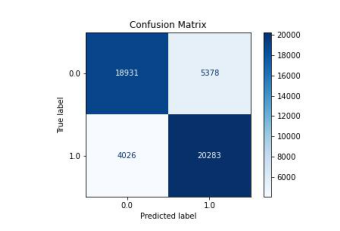

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.892


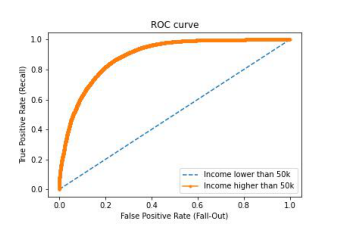


       ***************  Logistic_regression  ***************

Coefficients for feature importance: 

('capital-gain', 5.120438802279514)
('hours-per-week', 3.2950218046179365)
('age', 2.1213838070023474)
('marital-status_Married-civ-spouse', 1.6316080278785352)
('occupation_Prof-specialty', 1.6135605080799902)
('marital-status_Married-AF-spouse', 1.4434614630386897)
('capital-loss', 1.4215824443232286)
('occupation_Exec-managerial', 1.3298007039409703)
('relationship_Wife', 1.166563898661747)
('occupation_Tech-support', 0.9705028838744911)
('occupation_Protective-serv', 0.7386911854380931)
('occupation_Sales', 0.6346345501380675)
('workclass_Federal-gov', 0.5567010874762773)
('race_Asian-Pac-Islander', 0.49703531657441713)
('relationship_Not-in-family', 0.39039628772088525)
('race_White', 0.3396711982489582)
('gender_Male', 0.2891676187536662)
('workclass_Self-emp-inc', 0.2308249706170906)
('occupation_Adm-clerical', 0.22607279566772565)
('workclass_Private', 0.1118087505283379)
('occ

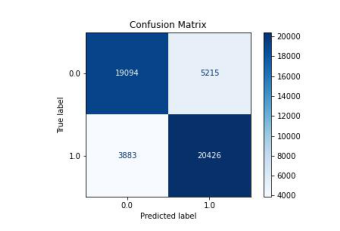

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.894


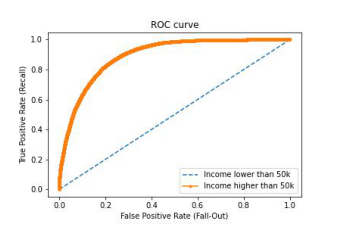

In [186]:
for model_name,model in model_dict.items():
    evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep)

In [ ]:
# TODO: Create a requirements.txt at the end of the project
# TODO: Do feature importance analysis
